In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

import numpy as np
import pandas as pd
import random
import wandb
from tqdm.auto import tqdm
import os
import math

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.font_manager as font_manager


In [2]:
compute_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
compute_device

device(type='cuda')

In [3]:
from kaggle_secrets import UserSecretsClient

secrets = UserSecretsClient()
wandb_key = secrets.get_secret("WANDB_API_KEY")

wandb.login(key=wandb_key)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cs24m023 (cs24m023-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Data Receiving

In [4]:
path_train = "/kaggle/input/dakshina001/hi/lexicons/hi.translit.sampled.train.tsv"
path_dev = "/kaggle/input/dakshina001/hi/lexicons/hi.translit.sampled.dev.tsv"
path_test = "/kaggle/input/dakshina001/hi/lexicons/hi.translit.sampled.test.tsv"

## Data Loading and Preprocessing

In [5]:
# Load the datasets into DataFrames
df_train = pd.read_csv(path_train, sep="\t", header=None)
df_val = pd.read_csv(path_dev, sep="\t", header=None)
df_test = pd.read_csv(path_test, sep="\t", header=None)

# Assign column names
df_train.columns = ['devanagari', 'latin', 'frequency']
df_val.columns = ['devanagari', 'latin', 'frequency']
df_test.columns = ['devanagari', 'latin', 'frequency']

# Display dataset sizes
print(f"Training Set Size : {len(df_train)}")
print(f"Validation Set Size: {len(df_val)}")
print(f"Test Set Size     : {len(df_test)}")

Train Dataset Size : 44204
Dev Dataset Size   : 4358
Test Dataset Size  : 4502


In [6]:
train_df.head()

,devanagari,latin,frequency
0,अं,an,3
1,अंकगणित,ankganit,3
2,अंकल,uncle,4
3,अंकुर,ankur,4
4,अंकुरण,ankuran,3


In [7]:
# Ensure this is imported for tensor handling in decode

class CharacterLexicon:
    def __init__(self):
        # Reserved tokens
        self._padding = "<pad>"
        self._start = "<sos>"
        self._end = "<eos>"
        self._unknown = "<unk>"

        # Internal mappings
        self.char2idx = {
            self._padding: 0,
            self._start: 1,
            self._end: 2,
            self._unknown: 3
        }
        self.idx2char = {idx: char for char, idx in self.char2idx.items()}
        self._counter = len(self.char2idx)

    def populate(self, text_data):
        for sequence in text_data:
            for symbol in str(sequence):
                if symbol not in self.char2idx:
                    self.char2idx[symbol] = self._counter
                    self.idx2char[self._counter] = symbol
                    self._counter += 1

    def text_to_indices(self, sequence, include_tokens=True):
        encoded = [self.char2idx.get(ch, self.char2idx[self._unknown]) for ch in str(sequence)]
        if include_tokens:
            return [self.char2idx[self._start]] + encoded + [self.char2idx[self._end]]
        return encoded

    def indices_to_text(self, indices, exclude_special=True):
        output = []
        for idx in indices:
            idx = idx.item() if isinstance(idx, torch.Tensor) else idx
            symbol = self.idx2char.get(idx, "")
            if exclude_special and symbol in {self._padding, self._start, self._end, self._unknown}:
                continue
            output.append(symbol)
        return ''.join(output)


In [8]:
class SeqPairDataset(Dataset):
    def __init__(self, data_path, src_lexicon, tgt_lexicon, delimiter='\t'):
        # Load tab-separated pairs: target in col 0, source in col 1
        df = pd.read_csv(data_path, sep=delimiter, header=None, names=['target', 'source'])
        
        # Pre-encode all sequences once
        self._src_sequences = [
            src_lexicon.text_to_indices(seq) for seq in df['source']
        ]
        self._tgt_sequences = [
            tgt_lexicon.text_to_indices(seq) for seq in df['target']
        ]

    def __len__(self):
        return len(self._src_sequences)

    def __getitem__(self, index):
        src_seq = torch.tensor(self._src_sequences[index], dtype=torch.long)
        tgt_seq = torch.tensor(self._tgt_sequences[index], dtype=torch.long)
        return src_seq, tgt_seq

In [9]:
ef batch_collator(batch):
    """
    Assemble a batch of (source, target) sequence tensors, padding them to equal length.
    
    Args:
        batch (List[Tuple[Tensor, Tensor]]): List of (src_tensor, tgt_tensor) pairs.
        
    Returns:
        Tuple[Tensor, Tensor]: (padded_sources, padded_targets)
    """
    # Unzip the list of tuples into two lists
    src_seqs, tgt_seqs = zip(*batch)
    
    # Pad sequences along the time dimension (first axis after batch)
    # Assumes 0 is the padding index
    padded_sources = pad_sequence(src_seqs, batch_first=True, padding_value=0)
    padded_targets = pad_sequence(tgt_seqs, batch_first=True, padding_value=0)
    
    return padded_sources, padded_targets

In [ ]:
# Construct vocabularies for source (Latin) and target (Devanagari) scripts
# Initialize source (Latin) and target (Devanagari) lexicons
src_lexicon = CharacterLexicon()
tgt_lexicon = CharacterLexicon()

# Load the training file: column 0 = target, column 1 = source
df_train = pd.read_csv(path_train, sep='\t', header=None, names=['target', 'source'])

# Populate each lexicon from its respective text column
src_lexicon.populate(df_train['source'])
tgt_lexicon.populate(df_train['target'])

In [11]:
# Train, Test and Dev (Validation) Dataset and Dataloaders
# Filepath variables (adjust as needed)
train_path = TRAIN_FilePath
val_path   = DEV_FilePath
test_path  = TEST_FilePath

# Instantiate datasets
train_set = SeqPairDataset(train_path, src_lexicon, tgt_lexicon)
val_set   = SeqPairDataset(val_path,   src_lexicon, tgt_lexicon)
test_set  = SeqPairDataset(test_path,  src_lexicon, tgt_lexicon)

# Create DataLoaders
train_loader = DataLoader(
    train_set,
    batch_size=32,
    shuffle=True,
    collate_fn=batch_collator
)

val_loader = DataLoader(
    val_set,
    batch_size=32,
    shuffle=False,
    collate_fn=batch_collator
)

test_loader = DataLoader(
    test_set,
    batch_size=32,
    shuffle=False,
    collate_fn=batch_collator
)

In [12]:
# Quick sanity check on the training DataLoader
for batch_data in train_loader:
    src_batch, tgt_batch = batch_data

    # Print batch tensor shapes
    print(f"Shape of source batch: {src_batch.size()}")
    print(f"Shape of target batch: {tgt_batch.size()}")

    # Inspect the first sequence pair in the batch
    first_src, first_tgt = src_batch[0], tgt_batch[0]
    print("Inputs shape:", first_src)
    print("Targets shape:", first_tgt)

    # Decode back to text (skipping special tokens)
    decoded_src = src_lexicon.indices_to_text(first_src)
    decoded_tgt = tgt_lexicon.indices_to_text(first_tgt)
    print("Sample input:", decoded_src)
    print("Sample target:", decoded_tgt)

    # Only inspect the first batch
    break

Inputs shape: torch.Size([32, 17])
Targets shape: torch.Size([32, 17])
Sample input: tensor([ 1,  4,  5,  9,  9, 20,  7,  9, 24,  4,  2,  0,  0,  0,  0,  0,  0])
Sample target: tensor([ 1,  4,  5, 10, 10, 25,  7, 10, 19, 32, 21,  2,  0,  0,  0,  0,  0])
anttogtva
अंततोगत्वा


## Our Vanilla Model

In [15]:

class SeqEncoder(nn.Module):
    def __init__(
        self,
        vocab_size,
        embed_dim,
        hidden_dim,
        layers=1,
        rnn_type="RNN",
        drop_p=0.0
    ):
        super(SeqEncoder, self).__init__()

        # If only one layer, disable dropout in the recurrent module
        effective_drop = 0.0 if layers == 1 else drop_p

        # Store the RNN variant
        self.rnn_type = rnn_type.upper()

        # Token embedding
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)

        # Choose the recurrent block
        rnn_kwargs = dict(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=layers,
            dropout=effective_drop,
            batch_first=True
        )
        if self.rnn_type == "LSTM":
            self.rnn = nn.LSTM(**rnn_kwargs)
        elif self.rnn_type == "GRU":
            self.rnn = nn.GRU(**rnn_kwargs)
        else:
            self.rnn = nn.RNN(**rnn_kwargs)

        # Optional dropout on embeddings
        self.embed_dropout = nn.Dropout(p=drop_p)

    def forward(self, src_seq):
        """
        Args:
            src_seq (LongTensor): shape (batch_size, seq_len)
        Returns:
            outputs: all hidden states for each time step
            state: hidden (and cell) state(s) at final time step
        """
        # Embed and apply dropout
        x = self.embedding(src_seq)           # -> (batch, seq_len, embed_dim)
        x = self.embed_dropout(x)

        # Run through the RNN/LSTM/GRU
        if self.rnn_type == "LSTM":
            outputs, (h_n, c_n) = self.rnn(x)
            return outputs, (h_n, c_n)
        else:
            outputs, h_n = self.rnn(x)
            return outputs, h_n


In [16]:

class SeqDecoder(nn.Module):
    def __init__(
        self,
        vocab_size,
        embed_dim,
        hidden_dim,
        layers=1,
        rnn_type="RNN",
        drop_p=0.0
    ):
        super(SeqDecoder, self).__init__()

        # Disable internal dropout if only one layer
        internal_drop = 0.0 if layers == 1 else drop_p

        self.rnn_type = rnn_type.upper()
        self.vocab_size = vocab_size

        # Embedding + dropout
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)
        self.embed_dropout = nn.Dropout(p=drop_p)

        # Recurrent block
        rnn_args = dict(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=layers,
            dropout=internal_drop,
            batch_first=True
        )
        if self.rnn_type == "LSTM":
            self.rnn = nn.LSTM(**rnn_args)
        elif self.rnn_type == "GRU":
            self.rnn = nn.GRU(**rnn_args)
        else:
            self.rnn = nn.RNN(**rnn_args)

        # Final projection to vocabulary
        self.output_proj = nn.Linear(hidden_dim, vocab_size)

    def forward(self, token, state):
        """
        Args:
            token (LongTensor): shape (batch_size,), one time-step of input tokens
            state: previous hidden (and cell) state(s)
        Returns:
            logits (Tensor): shape (batch_size, vocab_size)
            new_state: updated hidden (and cell) state(s)
        """
        # (batch,) → (batch, 1)
        token = token.unsqueeze(1)
        x = self.embedding(token)       # → (batch, 1, embed_dim)
        x = self.embed_dropout(x)

        # Run one step through RNN/LSTM/GRU
        if self.rnn_type == "LSTM":
            h_prev, c_prev = state
            outputs, (h_new, c_new) = self.rnn(x, (h_prev, c_prev))
            new_state = (h_new, c_new)
        else:
            outputs, h_new = self.rnn(x, state)
            new_state = h_new

        # Remove time dimension: (batch, 1, hidden_dim) → (batch, hidden_dim)
        outputs = outputs.squeeze(1)
        logits = self.output_proj(outputs)

        return logits, new_state


In [17]:
import random
import torch
import torch.nn as nn

class SequenceTranslator(nn.Module):
    def __init__(self, enc_module, dec_module, device):
        super(SequenceTranslator, self).__init__()
        self.encoder = enc_module
        self.decoder = dec_module
        self.device = device

    def translate(self, src_batch, tgt_batch, teacher_forcing=0.5):
        """
        Perform a full seq2seq pass with optional teacher forcing.
        
        Args:
            src_batch (LongTensor): shape (B, S_in)
            tgt_batch (LongTensor): shape (B, S_out)
            teacher_forcing (float): probability of using ground-truth token
            
        Returns:
            Tensor: logits of shape (B, S_out, V_out)
        """
        B, S_out = tgt_batch.size()
        V_out = self.decoder.vocab_size

        # Prepare output storage
        logits = torch.zeros(B, S_out, V_out, device=self.device)

        # Encode source
        if self.encoder.rnn_type == "LSTM":
            _, (h_enc, c_enc) = self.encoder(src_batch)
            dec_state = (h_enc, c_enc)
        else:
            _, h_enc = self.encoder(src_batch)
            dec_state = h_enc

        # First decoder input is always <sos>
        decoder_input = tgt_batch[:, 0]

        # Step through target sequence
        for t in range(1, S_out):
            dec_logits, dec_state = self.decoder(decoder_input, dec_state)
            logits[:, t] = dec_logits

            top_tokens = dec_logits.argmax(dim=1)
            use_teacher = random.random() < teacher_forcing
            decoder_input = tgt_batch[:, t] if use_teacher else top_tokens

        return logits

    def generate(self, src_batch, max_length, sos_index=1, eos_index=2):
        """
        Generate translations without teacher forcing, stopping at <eos>.
        
        Args:
            src_batch (LongTensor): shape (B, S_in)
            max_length (int): maximum output length
            sos_index (int): index of start token
            eos_index (int): index of end token
            
        Returns:
            Tensor: logits of shape (B, max_length, V_out)
        """
        B = src_batch.size(0)
        V_out = self.decoder.vocab_size

        logits = torch.zeros(B, max_length, V_out, device=self.device)

        # Encode source
        if self.encoder.rnn_type == "LSTM":
            _, (h_enc, c_enc) = self.encoder(src_batch)
            dec_state = (h_enc, c_enc)
        else:
            _, h_enc = self.encoder(src_batch)
            dec_state = h_enc

        # Initialize with <sos> tokens
        decoder_input = torch.full((B,), sos_index, dtype=torch.long, device=self.device)

        for t in range(1, max_length):
            dec_logits, dec_state = self.decoder(decoder_input, dec_state)
            logits[:, t] = dec_logits

            top_tokens = dec_logits.argmax(dim=1)
            decoder_input = top_tokens

            # Stop early if every sequence has produced <eos>
            # We check the argmax predictions, not the logits tensor itself.
            if (top_tokens == eos_index).all():
                break

        return logits


## Training and Evaluation of our Vanilla Model

In [18]:
def run_epoch(
    model,
    data_loader,
    optimizer,
    loss_fn,
    clip_value=1.0,
    teacher_forcing_prob=0.5,
    device=None
):
    """
    Train the seq2seq model for one epoch.
    
    Args:
        model (nn.Module): Seq2Seq model with `.translate()` method.
        data_loader (DataLoader): Yields (src_batch, tgt_batch) pairs.
        optimizer (Optimizer): Optimizer for parameter updates.
        loss_fn (callable): Loss function (e.g., nn.CrossEntropyLoss).
        clip_value (float): Max-norm for gradient clipping.
        teacher_forcing_prob (float): Probability to use teacher forcing.
        device (torch.device): Device to run computations on.
        
    Returns:
        float: Average loss over the epoch.
    """
    model.train()
    total_loss = 0.0

    for src_batch, tgt_batch in data_loader:
        # Move batches to the appropriate device
        if device is not None:
            src_batch = src_batch.to(device)
            tgt_batch = tgt_batch.to(device)

        optimizer.zero_grad()

        # Forward pass: returns logits shaped (B, T_out, V_out)
        logits = model.translate(
            src_batch,
            tgt_batch,
            teacher_forcing=teacher_forcing_prob
        )

        # Shift off the first token (<sos>) when computing loss
        B, T_out, V_out = logits.shape
        logits_flat = logits[:, 1:].reshape(-1, V_out)
        targets_flat = tgt_batch[:, 1:].reshape(-1)

        # Compute and backpropagate loss
        loss = loss_fn(logits_flat, targets_flat)
        loss.backward()

        # Clip gradients and step optimizer
        clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    return avg_loss

In [19]:
def assess_model(
    model,
    data_loader,
    loss_fn,
    device=None
):
    """
    Evaluate the seq2seq model on a validation or test set.
    
    Args:
        model (nn.Module): SequenceTranslator with `.generate()` method.
        data_loader (DataLoader): Yields (src_batch, tgt_batch) pairs.
        loss_fn (callable): Loss function (e.g., nn.CrossEntropyLoss).
        device (torch.device, optional): Device for computation.
        
    Returns:
        float: Average loss over the dataset.
    """
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for src_batch, tgt_batch in data_loader:
            # Move to device if specified
            if device is not None:
                src_batch = src_batch.to(device)
                tgt_batch = tgt_batch.to(device)

            # Generate logits without teacher forcing
            max_len = tgt_batch.size(1)
            logits = model.generate(src_batch, max_length=max_len)

            # Flatten away the first <sos> step
            B, T, V = logits.shape
            logits_flat = logits[:, 1:].reshape(-1, V)
            targets_flat = tgt_batch[:, 1:].reshape(-1)

            # Accumulate loss
            loss = loss_fn(logits_flat, targets_flat)
            total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    return avg_loss


In [20]:
def infer_transliteration(
    translator: nn.Module,
    source_str: str,
    src_lexicon,
    tgt_lexicon,
    device: torch.device,
    max_steps: int = 100
) -> str:
    """
    Perform greedy, character‑level transliteration of a single string.
    
    Args:
        translator (SequenceTranslator): trained seq2seq model
        source_str (str): input string in source script
        src_lexicon: CharacterLexicon for source script
        tgt_lexicon: CharacterLexicon for target script
        device (torch.device): computation device
        max_steps (int): max output length (including <sos> and <eos>)
        
    Returns:
        str: transliterated string (without special tokens)
    """
    translator.eval()
    
    # Encode input and make batch of size 1
    input_indices = src_lexicon.text_to_indices(source_str, include_tokens=True)
    input_tensor = torch.tensor(input_indices, dtype=torch.long, device=device).unsqueeze(0)
    
    # Encode and get initial decoder state
    with torch.no_grad():
        if translator.encoder.rnn_type == "LSTM":
            _, (h_enc, c_enc) = translator.encoder(input_tensor)
            dec_state = (h_enc, c_enc)
        else:
            _, h_enc = translator.encoder(input_tensor)
            dec_state = h_enc
    
    # Initialize with <sos>
    sos_idx = tgt_lexicon.char2idx[tgt_lexicon._start]
    eos_idx = tgt_lexicon.char2idx[tgt_lexicon._end]
    current_token = torch.tensor([sos_idx], dtype=torch.long, device=device)
    
    # Collect output token indices
    output_indices = [sos_idx]
    
    for _ in range(max_steps - 1):
        with torch.no_grad():
            logits, dec_state = translator.decoder(current_token, dec_state)
        next_idx = logits.argmax(dim=1).item()
        output_indices.append(next_idx)
        
        if next_idx == eos_idx:
            break
        
        current_token = torch.tensor([next_idx], dtype=torch.long, device=device)
    
    # Convert back to string, skipping special tokens
    transliterated = tgt_lexicon.indices_to_text(output_indices, exclude_special=True)
    return transliterated

In [21]:

def compute_accuracy(
    translator: nn.Module,
    data_loader: DataLoader,
    src_lexicon,
    tgt_lexicon,
    device: torch.device
) -> float:
    """
    Calculate exact-match accuracy of the seq2seq transliteration model.
    
    Args:
        translator (nn.Module): SequenceTranslator with `.generate()` or `infer_transliteration()`.
        data_loader (DataLoader): Yields (src_batch, tgt_batch) pairs.
        src_lexicon: CharacterLexicon for source script.
        tgt_lexicon: CharacterLexicon for target script.
        device (torch.device): Device for computation.
    
    Returns:
        float: fraction of examples where predicted string == target string.
    """
    translator.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for src_batch, tgt_batch in data_loader:
            # Move to device
            src_batch = src_batch.to(device)
            tgt_batch = tgt_batch.to(device)
            
            # Iterate over examples in the batch
            for src_seq, tgt_seq in zip(src_batch, tgt_batch):
                # Decode tensor sequences to clean strings (no special tokens)
                src_str = src_lexicon.indices_to_text(src_seq, exclude_special=True)
                true_str = tgt_lexicon.indices_to_text(tgt_seq, exclude_special=True)
                
                # Get model prediction
                pred_str = infer_transliteration(
                    translator, src_str, src_lexicon, tgt_lexicon, device
                )
                
                # Exact-match check
                if pred_str == true_str:
                    correct += 1
                total += 1

    return correct / total if total > 0 else 0.0


## Hyperparameter Tuning of our Vanilla Model

In [25]:
def hyperparameter_search(default_config=None):
    """
    Perform a hyperparameter sweep for the seq2seq transliteration model using Weights & Biases.
    """
    with wandb.init(config=default_config):
        cfg = wandb.config
        # Name the run for easy identification
        wandb.run.name = (
            f"emb{cfg.embedding_size}_layers{cfg.num_layers}"
            f"_hid{cfg.hidden_size}_cell{cfg.cell_type}"
            f"_drop{cfg.dropout}_lr{cfg.learning_rate}_bs{cfg.batch_size}"
        )
        # Log author info
        wandb.config.update({"author": "LOKESH TALAMALA", "roll_no": "CS24M023"})

        # Prepare DataLoaders
        train_ds = SeqPairDataset(TRAIN_FilePath, src_lexicon, tgt_lexicon)
        val_ds   = SeqPairDataset(DEV_FilePath,   src_lexicon, tgt_lexicon)

        train_loader = DataLoader(
            train_ds,
            batch_size=cfg.batch_size,
            shuffle=True,
            collate_fn=batch_collator
        )
        val_loader = DataLoader(
            val_ds,
            batch_size=cfg.batch_size,
            shuffle=False,
            collate_fn=batch_collator
        )

        # Hyperparameters
        V_src = src_lexicon.char2idx.__len__()
        V_tgt = tgt_lexicon.char2idx.__len__()
        E = cfg.embedding_size
        H = cfg.hidden_size
        L = cfg.num_layers
        C = cfg.cell_type
        D = cfg.dropout
        LR = cfg.learning_rate
        epochs = 10

        # Build model
        enc = SeqEncoder(
            vocab_size=V_src,
            embed_dim=E,
            hidden_dim=H,
            layers=L,
            rnn_type=C,
            drop_p=D
        )
        dec = SeqDecoder(
            vocab_size=V_tgt,
            embed_dim=E,
            hidden_dim=H,
            layers=L,
            rnn_type=C,
            drop_p=D
        )
        model = SequenceTranslator(enc, dec, device).to(device)

        # Loss and optimizer
        criterion = nn.CrossEntropyLoss(ignore_index=src_lexicon.char2idx[src_lexicon._padding])
        optimizer = optim.Adam(model.parameters(), lr=LR)

        # Training loop
        for ep in tqdm(range(epochs), desc="Epochs"):
            train_loss = run_epoch(
                model,
                train_loader,
                optimizer,
                loss_fn=criterion,
                clip_value=1.0,
                teacher_forcing_prob=0.5,
                device=device
            )
            val_loss = assess_model(
                model,
                val_loader,
                loss_fn=criterion,
                device=device
            )

            print(f"[Epoch {ep+1}/{epochs}] Train: {train_loss:.4f} | Val: {val_loss:.4f}")
            wandb.log({
                "epoch": ep + 1,
                "train_loss": train_loss,
                "val_loss": val_loss
            })

        # Final validation accuracy
        accuracy = compute_accuracy(
            model,
            val_loader,
            src_lexicon,
            tgt_lexicon,
            device=device
        )
        print(f"Validation Accuracy: {accuracy:.4f}")
        wandb.log({"val_accuracy": accuracy})


In [26]:
sweep_config = {
    "method" : "bayes",
    "metric" : {"name": "val_accuracy", "goal": "maximize"},
    "parameters" : {
        "embedding_size" : {"values" : [16, 64, 256]},
        "num_layers" : {"values" : [2, 3]},
        "hidden_size" : {"values" : [32, 128, 512]},
        "cell_type" : {"values" : ["RNN", "LSTM", "GRU"]},
        "dropout" : {"values" : [ 0.2, 0.3]},
        "learning_rate" : {"values" : [0.001, 0.0005]},
        "batch_size": {"values": [ 64, 128]}
    }
}

sweep_id = wandb.sweep(sweep_config, project = "Deep_Learning_Assignment_3")
wandb.agent(sweep_id, function = sweep_hyperparameters, count = 30)

Create sweep with ID: l9aas5i7
Sweep URL: https://wandb.ai/cs24m023-indian-institute-of-technology-madras/Deep_Learning_Assignment_3/sweeps/l9aas5i7


wandb: Agent Starting Run: lh7mwhug with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	embedding_size: 64
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0005
wandb: 	num_layers: 3


 10%|█         | 1/10 [00:22<03:21, 22.36s/it]

Train Loss: 1.8625 | Valid Loss: 2.0275


 20%|██        | 2/10 [00:43<02:55, 21.93s/it]

Train Loss: 1.5107 | Valid Loss: 1.7007


 30%|███       | 3/10 [01:06<02:33, 21.99s/it]

Train Loss: 1.1970 | Valid Loss: 1.3571


 40%|████      | 4/10 [01:28<02:11, 22.00s/it]

Train Loss: 0.9458 | Valid Loss: 1.1352


 50%|█████     | 5/10 [01:49<01:49, 21.93s/it]

Train Loss: 0.7918 | Valid Loss: 1.0490


 60%|██████    | 6/10 [02:11<01:27, 21.99s/it]

Train Loss: 0.6913 | Valid Loss: 0.9613


 70%|███████   | 7/10 [02:34<01:06, 22.01s/it]

Train Loss: 0.6333 | Valid Loss: 0.8993


 80%|████████  | 8/10 [02:55<00:43, 21.97s/it]

Train Loss: 0.5861 | Valid Loss: 0.8766


 90%|█████████ | 9/10 [03:18<00:22, 22.09s/it]

Train Loss: 0.5459 | Valid Loss: 0.8677


100%|██████████| 10/10 [03:40<00:00, 22.06s/it]

Train Loss: 0.5224 | Valid Loss: 0.8618



Validation Accuracy: 0.2221


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▆▅▃▂▂▂▁▁▁
val_accuracy,▁
validation_loss,█▆▄▃▂▂▁▁▁▁
epoch,9
train_loss,0.52241
val_accuracy,0.22212
validation_loss,0.86179


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wxrwn1fv with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	embedding_size: 64
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3


 10%|█         | 1/10 [00:22<03:19, 22.18s/it]

Train Loss: 1.7528 | Valid Loss: 1.9296


 20%|██        | 2/10 [00:44<02:56, 22.10s/it]

Train Loss: 1.1796 | Valid Loss: 1.1772


 30%|███       | 3/10 [01:06<02:34, 22.08s/it]

Train Loss: 0.7632 | Valid Loss: 0.9896


 40%|████      | 4/10 [01:28<02:12, 22.10s/it]

Train Loss: 0.6037 | Valid Loss: 0.9010


 50%|█████     | 5/10 [01:50<01:49, 21.94s/it]

Train Loss: 0.5276 | Valid Loss: 0.8552


 60%|██████    | 6/10 [02:12<01:27, 21.99s/it]

Train Loss: 0.4724 | Valid Loss: 0.8679


 70%|███████   | 7/10 [02:34<01:05, 21.98s/it]

Train Loss: 0.4390 | Valid Loss: 0.8390


 80%|████████  | 8/10 [02:55<00:43, 21.92s/it]

Train Loss: 0.4047 | Valid Loss: 0.8433


 90%|█████████ | 9/10 [03:18<00:21, 21.99s/it]

Train Loss: 0.3809 | Valid Loss: 0.8289


100%|██████████| 10/10 [03:40<00:00, 22.03s/it]

Train Loss: 0.3587 | Valid Loss: 0.7959



Validation Accuracy: 0.2981


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁
validation_loss,█▃▂▂▁▁▁▁▁▁
epoch,9
train_loss,0.35873
val_accuracy,0.29807
validation_loss,0.79589


wandb: Agent Starting Run: n25w9tau with config:
wandb: 	batch_size: 128
wandb: 	cell_type: RNN
wandb: 	dropout: 0.2
wandb: 	embedding_size: 64
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 2


 10%|█         | 1/10 [00:08<01:14,  8.30s/it]

Train Loss: 2.0613 | Valid Loss: 2.2302


 20%|██        | 2/10 [00:16<01:07,  8.49s/it]

Train Loss: 1.7052 | Valid Loss: 2.2270


 30%|███       | 3/10 [00:25<00:59,  8.45s/it]

Train Loss: 1.6603 | Valid Loss: 2.1354


 40%|████      | 4/10 [00:33<00:50,  8.41s/it]

Train Loss: 1.6308 | Valid Loss: 2.2628


 50%|█████     | 5/10 [00:41<00:41,  8.34s/it]

Train Loss: 1.6136 | Valid Loss: 2.1887


 60%|██████    | 6/10 [00:50<00:33,  8.43s/it]

Train Loss: 1.6033 | Valid Loss: 2.3388


 70%|███████   | 7/10 [00:58<00:25,  8.44s/it]

Train Loss: 1.5968 | Valid Loss: 2.2110


 80%|████████  | 8/10 [01:07<00:16,  8.44s/it]

Train Loss: 1.5919 | Valid Loss: 2.1761


 90%|█████████ | 9/10 [01:15<00:08,  8.43s/it]

Train Loss: 1.6018 | Valid Loss: 2.1926


100%|██████████| 10/10 [01:24<00:00,  8.44s/it]

Train Loss: 1.5839 | Valid Loss: 2.1927



Validation Accuracy: 0.0000


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁
validation_loss,▄▄▁▅▃█▄▂▃▃
epoch,9
train_loss,1.58394
val_accuracy,0
validation_loss,2.19267


wandb: Agent Starting Run: 5xwvn9fm with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.2
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3


 10%|█         | 1/10 [00:24<03:39, 24.36s/it]

Train Loss: 0.8331 | Valid Loss: 0.8556


 20%|██        | 2/10 [00:48<03:14, 24.37s/it]

Train Loss: 0.4015 | Valid Loss: 0.8170


 30%|███       | 3/10 [01:12<02:49, 24.15s/it]

Train Loss: 0.3265 | Valid Loss: 0.8240


 40%|████      | 4/10 [01:36<02:24, 24.12s/it]

Train Loss: 0.2782 | Valid Loss: 0.7792


 50%|█████     | 5/10 [02:00<02:00, 24.07s/it]

Train Loss: 0.2465 | Valid Loss: 0.8101


 60%|██████    | 6/10 [02:24<01:35, 23.97s/it]

Train Loss: 0.2267 | Valid Loss: 0.8474


 70%|███████   | 7/10 [02:48<01:11, 23.84s/it]

Train Loss: 0.2105 | Valid Loss: 0.8731


 80%|████████  | 8/10 [03:12<00:47, 23.91s/it]

Train Loss: 0.2064 | Valid Loss: 0.8622


 90%|█████████ | 9/10 [03:36<00:23, 23.99s/it]

Train Loss: 0.1967 | Valid Loss: 0.9184


100%|██████████| 10/10 [03:59<00:00, 23.99s/it]

Train Loss: 0.1902 | Valid Loss: 0.9240



Validation Accuracy: 0.3630


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁
validation_loss,▅▃▃▁▂▄▆▅██
epoch,9
train_loss,0.19019
val_accuracy,0.36301
validation_loss,0.92402


wandb: Agent Starting Run: tosd5vba with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3


 10%|█         | 1/10 [00:24<03:37, 24.17s/it]

Train Loss: 0.8592 | Valid Loss: 0.9099


 20%|██        | 2/10 [00:47<03:11, 23.96s/it]

Train Loss: 0.4344 | Valid Loss: 0.8449


 30%|███       | 3/10 [01:11<02:47, 23.97s/it]

Train Loss: 0.3591 | Valid Loss: 0.7754


 40%|████      | 4/10 [01:35<02:23, 23.98s/it]

Train Loss: 0.3100 | Valid Loss: 0.8138


 50%|█████     | 5/10 [01:59<01:59, 23.90s/it]

Train Loss: 0.2853 | Valid Loss: 0.8289


 60%|██████    | 6/10 [02:23<01:35, 23.88s/it]

Train Loss: 0.2670 | Valid Loss: 0.8340


 70%|███████   | 7/10 [02:47<01:11, 23.85s/it]

Train Loss: 0.2555 | Valid Loss: 0.8111


 80%|████████  | 8/10 [03:10<00:47, 23.76s/it]

Train Loss: 0.2435 | Valid Loss: 0.8498


 90%|█████████ | 9/10 [03:34<00:23, 23.77s/it]

Train Loss: 0.2354 | Valid Loss: 0.8653


100%|██████████| 10/10 [03:58<00:00, 23.83s/it]

Train Loss: 0.2352 | Valid Loss: 0.8666



Validation Accuracy: 0.3722


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁
validation_loss,█▅▁▃▄▄▃▅▆▆
epoch,9
train_loss,0.23521
val_accuracy,0.37219
validation_loss,0.86665


wandb: Agent Starting Run: mpjr876e with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3


 10%|█         | 1/10 [00:23<03:33, 23.75s/it]

Train Loss: 0.8461 | Valid Loss: 0.9012


 20%|██        | 2/10 [00:47<03:09, 23.75s/it]

Train Loss: 0.4221 | Valid Loss: 0.7972


 30%|███       | 3/10 [01:11<02:46, 23.73s/it]

Train Loss: 0.3470 | Valid Loss: 0.8127


 40%|████      | 4/10 [01:35<02:22, 23.81s/it]

Train Loss: 0.3068 | Valid Loss: 0.8355


 50%|█████     | 5/10 [01:58<01:58, 23.71s/it]

Train Loss: 0.2767 | Valid Loss: 0.8330


 60%|██████    | 6/10 [02:22<01:35, 23.76s/it]

Train Loss: 0.2606 | Valid Loss: 0.8360


 70%|███████   | 7/10 [02:46<01:11, 23.86s/it]

Train Loss: 0.2490 | Valid Loss: 0.8361


 80%|████████  | 8/10 [03:10<00:47, 23.91s/it]

Train Loss: 0.2409 | Valid Loss: 0.8512


 90%|█████████ | 9/10 [03:34<00:23, 23.83s/it]

Train Loss: 0.2322 | Valid Loss: 0.8915


100%|██████████| 10/10 [03:58<00:00, 23.81s/it]

Train Loss: 0.2235 | Valid Loss: 0.8911



Validation Accuracy: 0.3584


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁
validation_loss,█▁▂▄▃▄▄▅▇▇
epoch,9
train_loss,0.22346
val_accuracy,0.35842
validation_loss,0.89111


wandb: Agent Starting Run: sjrz0n44 with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3


 10%|█         | 1/10 [00:26<03:55, 26.21s/it]

Train Loss: 1.3680 | Valid Loss: 1.0583


 20%|██        | 2/10 [00:53<03:33, 26.63s/it]

Train Loss: 0.5100 | Valid Loss: 0.7840


 70%|███████   | 7/10 [03:05<01:19, 26.48s/it]

Train Loss: 0.1666 | Valid Loss: 0.8499


 80%|████████  | 8/10 [03:32<00:53, 26.59s/it]

Train Loss: 0.1459 | Valid Loss: 0.8641


 90%|█████████ | 9/10 [03:58<00:26, 26.63s/it]

Train Loss: 0.1261 | Valid Loss: 0.8596


100%|██████████| 10/10 [04:25<00:00, 26.56s/it]

Train Loss: 0.1178 | Valid Loss: 0.9094



Validation Accuracy: 0.3513


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁
validation_loss,█▂▂▁▂▂▃▄▄▅
epoch,9
train_loss,0.11784
val_accuracy,0.35131
validation_loss,0.90943


wandb: Agent Starting Run: khlw6ros with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.2
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3


 10%|█         | 1/10 [00:23<03:32, 23.63s/it]

Train Loss: 0.8346 | Valid Loss: 0.8377


 20%|██        | 2/10 [00:47<03:10, 23.86s/it]

Train Loss: 0.4116 | Valid Loss: 0.7711


 30%|███       | 3/10 [01:11<02:45, 23.68s/it]

Train Loss: 0.3283 | Valid Loss: 0.8095


 40%|████      | 4/10 [01:34<02:21, 23.66s/it]

Train Loss: 0.2741 | Valid Loss: 0.8150


 50%|█████     | 5/10 [01:58<01:58, 23.70s/it]

Train Loss: 0.2539 | Valid Loss: 0.8286


 60%|██████    | 6/10 [02:22<01:35, 23.77s/it]

Train Loss: 0.2312 | Valid Loss: 0.8535


 70%|███████   | 7/10 [02:45<01:11, 23.69s/it]

Train Loss: 0.2155 | Valid Loss: 0.9168


 80%|████████  | 8/10 [03:09<00:47, 23.72s/it]

Train Loss: 0.2055 | Valid Loss: 0.8605


 90%|█████████ | 9/10 [03:33<00:23, 23.69s/it]

Train Loss: 0.1957 | Valid Loss: 0.9316


100%|██████████| 10/10 [03:57<00:00, 23.74s/it]

Train Loss: 0.1929 | Valid Loss: 0.8939



Validation Accuracy: 0.3717


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁
validation_loss,▄▁▃▃▄▅▇▅█▆
epoch,9
train_loss,0.19291
val_accuracy,0.37173
validation_loss,0.89392


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qiic5d4i with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3


 10%|█         | 1/10 [00:23<03:32, 23.64s/it]

Train Loss: 0.8779 | Valid Loss: 0.8951


 20%|██        | 2/10 [00:47<03:09, 23.70s/it]

Train Loss: 0.4316 | Valid Loss: 0.8366


 30%|███       | 3/10 [01:10<02:45, 23.62s/it]

Train Loss: 0.3519 | Valid Loss: 0.8101


 40%|████      | 4/10 [01:34<02:22, 23.73s/it]

Train Loss: 0.3129 | Valid Loss: 0.8086


 50%|█████     | 5/10 [01:58<01:58, 23.64s/it]

Train Loss: 0.2860 | Valid Loss: 0.8024


 60%|██████    | 6/10 [02:21<01:34, 23.66s/it]

Train Loss: 0.2687 | Valid Loss: 0.8210


 70%|███████   | 7/10 [02:45<01:10, 23.63s/it]

Train Loss: 0.2547 | Valid Loss: 0.8447


 80%|████████  | 8/10 [03:09<00:47, 23.63s/it]

Train Loss: 0.2419 | Valid Loss: 0.8565


 90%|█████████ | 9/10 [03:33<00:23, 23.72s/it]

Train Loss: 0.2378 | Valid Loss: 0.8778


100%|██████████| 10/10 [03:56<00:00, 23.68s/it]

Train Loss: 0.2321 | Valid Loss: 0.8704



Validation Accuracy: 0.3587


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁
validation_loss,█▄▂▁▁▂▄▅▇▆
epoch,9
train_loss,0.23212
val_accuracy,0.35865
validation_loss,0.8704


wandb: Agent Starting Run: d8wnb04z with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3


 10%|█         | 1/10 [00:23<03:32, 23.57s/it]

Train Loss: 0.8759 | Valid Loss: 0.8691


 20%|██        | 2/10 [00:47<03:08, 23.57s/it]

Train Loss: 0.4361 | Valid Loss: 0.7806


 30%|███       | 3/10 [01:10<02:45, 23.60s/it]

Train Loss: 0.3504 | Valid Loss: 0.7827


 40%|████      | 4/10 [01:34<02:22, 23.76s/it]

Train Loss: 0.3112 | Valid Loss: 0.7958


 50%|█████     | 5/10 [01:58<01:59, 23.90s/it]

Train Loss: 0.2824 | Valid Loss: 0.7960


 60%|██████    | 6/10 [02:22<01:35, 23.80s/it]

Train Loss: 0.2579 | Valid Loss: 0.8535


 70%|███████   | 7/10 [02:46<01:11, 23.81s/it]

Train Loss: 0.2481 | Valid Loss: 0.8851


 80%|████████  | 8/10 [03:10<00:47, 23.82s/it]

Train Loss: 0.2339 | Valid Loss: 0.8808


 90%|█████████ | 9/10 [03:34<00:23, 23.82s/it]

Train Loss: 0.2333 | Valid Loss: 0.8606


100%|██████████| 10/10 [03:57<00:00, 23.79s/it]

Train Loss: 0.2289 | Valid Loss: 0.8784



Validation Accuracy: 0.3614


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁
validation_loss,▇▁▁▂▂▆██▆█
epoch,9
train_loss,0.22891
val_accuracy,0.3614
validation_loss,0.87844


wandb: Agent Starting Run: bcaj4c73 with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.2
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3


 10%|█         | 1/10 [00:23<03:35, 23.90s/it]

Train Loss: 0.8550 | Valid Loss: 0.8960


 20%|██        | 2/10 [00:47<03:10, 23.77s/it]

Train Loss: 0.4024 | Valid Loss: 0.8447


 30%|███       | 3/10 [01:11<02:46, 23.75s/it]

Train Loss: 0.3312 | Valid Loss: 0.7650


 40%|████      | 4/10 [01:35<02:23, 23.86s/it]

Train Loss: 0.2787 | Valid Loss: 0.8431


 50%|█████     | 5/10 [01:58<01:58, 23.78s/it]

Train Loss: 0.2550 | Valid Loss: 0.8697


 60%|██████    | 6/10 [02:22<01:35, 23.79s/it]

Train Loss: 0.2328 | Valid Loss: 0.8724


 70%|███████   | 7/10 [02:46<01:11, 23.73s/it]

Train Loss: 0.2164 | Valid Loss: 0.8399


 80%|████████  | 8/10 [03:10<00:47, 23.80s/it]

Train Loss: 0.2109 | Valid Loss: 0.8640


 90%|█████████ | 9/10 [03:34<00:23, 23.82s/it]

Train Loss: 0.2018 | Valid Loss: 0.8687


100%|██████████| 10/10 [03:58<00:00, 23.82s/it]

Train Loss: 0.1957 | Valid Loss: 0.9047



Validation Accuracy: 0.3692


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁
validation_loss,█▅▁▅▆▆▅▆▆█
epoch,9
train_loss,0.19572
val_accuracy,0.36921
validation_loss,0.90473


wandb: Agent Starting Run: mejt70gy with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3


 10%|█         | 1/10 [00:24<03:37, 24.17s/it]

Train Loss: 0.8496 | Valid Loss: 0.8911


 20%|██        | 2/10 [00:48<03:12, 24.12s/it]

Train Loss: 0.4311 | Valid Loss: 0.8142


 30%|███       | 3/10 [01:12<02:48, 24.10s/it]

Train Loss: 0.3491 | Valid Loss: 0.7961


 40%|████      | 4/10 [01:36<02:24, 24.04s/it]

Train Loss: 0.3102 | Valid Loss: 0.8266


 50%|█████     | 5/10 [02:00<02:00, 24.01s/it]

Train Loss: 0.2808 | Valid Loss: 0.8531


 60%|██████    | 6/10 [02:24<01:36, 24.05s/it]

Train Loss: 0.2598 | Valid Loss: 0.8668


 70%|███████   | 7/10 [02:48<01:12, 24.07s/it]

Train Loss: 0.2511 | Valid Loss: 0.8193


 80%|████████  | 8/10 [03:12<00:47, 23.96s/it]

Train Loss: 0.2427 | Valid Loss: 0.8531


 90%|█████████ | 9/10 [03:36<00:23, 23.94s/it]

Train Loss: 0.2392 | Valid Loss: 0.8768


100%|██████████| 10/10 [04:00<00:00, 24.01s/it]

Train Loss: 0.2309 | Valid Loss: 0.8804



Validation Accuracy: 0.3752


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁
validation_loss,█▂▁▃▅▆▃▅▇▇
epoch,9
train_loss,0.23085
val_accuracy,0.37517
validation_loss,0.8804


wandb: Agent Starting Run: dn1olou8 with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3


 10%|█         | 1/10 [00:23<03:35, 23.99s/it]

Train Loss: 0.8699 | Valid Loss: 0.8836


 20%|██        | 2/10 [00:47<03:11, 23.96s/it]

Train Loss: 0.4350 | Valid Loss: 0.7900


 30%|███       | 3/10 [01:11<02:47, 23.86s/it]

Train Loss: 0.3558 | Valid Loss: 0.7760


 40%|████      | 4/10 [01:35<02:23, 23.84s/it]

Train Loss: 0.3071 | Valid Loss: 0.8164


 50%|█████     | 5/10 [01:59<01:59, 23.90s/it]

Train Loss: 0.2874 | Valid Loss: 0.8187


 60%|██████    | 6/10 [02:24<01:36, 24.15s/it]

Train Loss: 0.2655 | Valid Loss: 0.8218


 70%|███████   | 7/10 [02:48<01:12, 24.23s/it]

Train Loss: 0.2519 | Valid Loss: 0.8478


 80%|████████  | 8/10 [03:12<00:48, 24.11s/it]

Train Loss: 0.2455 | Valid Loss: 0.8714


 90%|█████████ | 9/10 [03:36<00:24, 24.12s/it]

Train Loss: 0.2388 | Valid Loss: 0.8711


100%|██████████| 10/10 [04:00<00:00, 24.05s/it]

Train Loss: 0.2341 | Valid Loss: 0.8568



Validation Accuracy: 0.3573


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁
validation_loss,█▂▁▄▄▄▆▇▇▆
epoch,9
train_loss,0.23408
val_accuracy,0.35727
validation_loss,0.85675


wandb: Agent Starting Run: szz0ajxv with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 16
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3


 10%|█         | 1/10 [00:24<03:36, 24.04s/it]

Train Loss: 1.3145 | Valid Loss: 0.9971


 20%|██        | 2/10 [00:47<03:11, 23.89s/it]

Train Loss: 0.6371 | Valid Loss: 0.8396


 30%|███       | 3/10 [01:11<02:47, 23.91s/it]

Train Loss: 0.4884 | Valid Loss: 0.7936


 40%|████      | 4/10 [01:35<02:24, 24.01s/it]

Train Loss: 0.4143 | Valid Loss: 0.7980


 50%|█████     | 5/10 [02:00<02:00, 24.05s/it]

Train Loss: 0.3706 | Valid Loss: 0.7866


 60%|██████    | 6/10 [02:24<01:36, 24.10s/it]

Train Loss: 0.3351 | Valid Loss: 0.8044


 70%|███████   | 7/10 [02:48<01:12, 24.02s/it]

Train Loss: 0.3065 | Valid Loss: 0.8225


 80%|████████  | 8/10 [03:11<00:47, 23.94s/it]

Train Loss: 0.2860 | Valid Loss: 0.8553


 90%|█████████ | 9/10 [03:35<00:23, 23.95s/it]

Train Loss: 0.2758 | Valid Loss: 0.8257


100%|██████████| 10/10 [03:59<00:00, 23.97s/it]

Train Loss: 0.2570 | Valid Loss: 0.8721



Validation Accuracy: 0.3366


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁
validation_loss,█▃▁▁▁▂▂▃▂▄
epoch,9
train_loss,0.257
val_accuracy,0.33662
validation_loss,0.87208


wandb: Agent Starting Run: 8hi55rc1 with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.2
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3


 10%|█         | 1/10 [00:24<03:38, 24.25s/it]

Train Loss: 0.8849 | Valid Loss: 0.8642


 20%|██        | 2/10 [00:48<03:12, 24.06s/it]

Train Loss: 0.4185 | Valid Loss: 0.8505


 30%|███       | 3/10 [01:12<02:47, 23.98s/it]

Train Loss: 0.3345 | Valid Loss: 0.8131


 40%|████      | 4/10 [01:36<02:24, 24.03s/it]

Train Loss: 0.2897 | Valid Loss: 0.8370


 50%|█████     | 5/10 [02:00<02:00, 24.17s/it]

Train Loss: 0.2622 | Valid Loss: 0.8540


 60%|██████    | 6/10 [02:24<01:36, 24.11s/it]

Train Loss: 0.2423 | Valid Loss: 0.8269


 70%|███████   | 7/10 [02:48<01:12, 24.09s/it]

Train Loss: 0.2263 | Valid Loss: 0.9007


 80%|████████  | 8/10 [03:12<00:48, 24.17s/it]

Train Loss: 0.2131 | Valid Loss: 0.9184


 90%|█████████ | 9/10 [03:36<00:24, 24.09s/it]

Train Loss: 0.2090 | Valid Loss: 0.9086


100%|██████████| 10/10 [04:00<00:00, 24.07s/it]

Train Loss: 0.2000 | Valid Loss: 0.8891



Validation Accuracy: 0.3534


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁
validation_loss,▄▃▁▃▄▂▇█▇▆
epoch,9
train_loss,0.20001
val_accuracy,0.35337
validation_loss,0.88907


wandb: Agent Starting Run: oihzh461 with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.2
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3


 10%|█         | 1/10 [00:24<03:37, 24.13s/it]

Train Loss: 0.8431 | Valid Loss: 0.8946


 20%|██        | 2/10 [00:48<03:11, 24.00s/it]

Train Loss: 0.4046 | Valid Loss: 0.7955


 30%|███       | 3/10 [01:12<02:48, 24.06s/it]

Train Loss: 0.3285 | Valid Loss: 0.8120


 40%|████      | 4/10 [01:36<02:24, 24.12s/it]

Train Loss: 0.2754 | Valid Loss: 0.8256


 50%|█████     | 5/10 [02:00<02:00, 24.07s/it]

Train Loss: 0.2498 | Valid Loss: 0.8037


 60%|██████    | 6/10 [02:24<01:36, 24.13s/it]

Train Loss: 0.2273 | Valid Loss: 0.8367


 70%|███████   | 7/10 [02:48<01:12, 24.14s/it]

Train Loss: 0.2189 | Valid Loss: 0.8617


 80%|████████  | 8/10 [03:12<00:48, 24.13s/it]

Train Loss: 0.2031 | Valid Loss: 0.8897


 90%|█████████ | 9/10 [03:36<00:24, 24.02s/it]

Train Loss: 0.1999 | Valid Loss: 0.8771


100%|██████████| 10/10 [04:00<00:00, 24.07s/it]

Train Loss: 0.1951 | Valid Loss: 0.8931



Validation Accuracy: 0.3557


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁
validation_loss,█▁▂▃▂▄▆█▇█
epoch,9
train_loss,0.19508
val_accuracy,0.35567
validation_loss,0.89314


wandb: Agent Starting Run: 2ph5kr4l with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.2
wandb: 	embedding_size: 16
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3


 10%|█         | 1/10 [00:23<03:33, 23.72s/it]

Train Loss: 1.2057 | Valid Loss: 0.9717


 20%|██        | 2/10 [00:47<03:09, 23.74s/it]

Train Loss: 0.5457 | Valid Loss: 0.8380


 30%|███       | 3/10 [01:11<02:46, 23.80s/it]

Train Loss: 0.4099 | Valid Loss: 0.8389


 40%|████      | 4/10 [01:35<02:22, 23.82s/it]

Train Loss: 0.3408 | Valid Loss: 0.8151


 50%|█████     | 5/10 [01:58<01:59, 23.81s/it]

Train Loss: 0.2977 | Valid Loss: 0.8206


 60%|██████    | 6/10 [02:23<01:35, 23.93s/it]

Train Loss: 0.2628 | Valid Loss: 0.8332


 70%|███████   | 7/10 [02:47<01:11, 23.96s/it]

Train Loss: 0.2392 | Valid Loss: 0.8496


 80%|████████  | 8/10 [03:11<00:47, 23.96s/it]

Train Loss: 0.2173 | Valid Loss: 0.8316


 90%|█████████ | 9/10 [03:34<00:23, 23.87s/it]

Train Loss: 0.2053 | Valid Loss: 0.8849


100%|██████████| 10/10 [03:58<00:00, 23.87s/it]

Train Loss: 0.1918 | Valid Loss: 0.8852



Validation Accuracy: 0.3488


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▁▁▁▁▁
val_accuracy,▁
validation_loss,█▂▂▁▁▂▃▂▄▄
epoch,9
train_loss,0.19184
val_accuracy,0.34878
validation_loss,0.88525


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kiwcyct0 with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3


 10%|█         | 1/10 [00:26<04:01, 26.78s/it]

Train Loss: 1.3829 | Valid Loss: 1.0613


 20%|██        | 2/10 [00:53<03:35, 26.89s/it]

Train Loss: 0.5198 | Valid Loss: 0.8367


 30%|███       | 3/10 [01:20<03:08, 27.00s/it]

Train Loss: 0.3641 | Valid Loss: 0.7914


 40%|████      | 4/10 [01:47<02:41, 26.97s/it]

Train Loss: 0.2882 | Valid Loss: 0.7553


 50%|█████     | 5/10 [02:14<02:14, 26.94s/it]

Train Loss: 0.2327 | Valid Loss: 0.8052


 60%|██████    | 6/10 [02:41<01:47, 26.92s/it]

Train Loss: 0.1959 | Valid Loss: 0.7962


 70%|███████   | 7/10 [03:08<01:20, 26.93s/it]

Train Loss: 0.1709 | Valid Loss: 0.7927


 80%|████████  | 8/10 [03:35<00:54, 27.02s/it]

Train Loss: 0.1485 | Valid Loss: 0.8535


 90%|█████████ | 9/10 [04:04<00:27, 27.56s/it]

Train Loss: 0.1276 | Valid Loss: 0.8926


100%|██████████| 10/10 [04:31<00:00, 27.12s/it]

Train Loss: 0.1160 | Valid Loss: 0.9071



Validation Accuracy: 0.3632


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁
validation_loss,█▃▂▁▂▂▂▃▄▄
epoch,9
train_loss,0.11598
val_accuracy,0.36324
validation_loss,0.9071


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c6f07jtw with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.2
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3


 10%|█         | 1/10 [00:23<03:35, 23.99s/it]

Train Loss: 0.8395 | Valid Loss: 0.8900


 20%|██        | 2/10 [00:47<03:11, 23.98s/it]

Train Loss: 0.4089 | Valid Loss: 0.8212


 30%|███       | 3/10 [01:12<02:48, 24.09s/it]

Train Loss: 0.3271 | Valid Loss: 0.8400


 40%|████      | 4/10 [01:36<02:24, 24.11s/it]

Train Loss: 0.2783 | Valid Loss: 0.8016


 50%|█████     | 5/10 [02:00<02:00, 24.16s/it]

Train Loss: 0.2499 | Valid Loss: 0.8495


 60%|██████    | 6/10 [02:24<01:36, 24.03s/it]

Train Loss: 0.2330 | Valid Loss: 0.8638


 70%|███████   | 7/10 [02:48<01:12, 24.10s/it]

Train Loss: 0.2129 | Valid Loss: 0.8706


 80%|████████  | 8/10 [03:12<00:48, 24.11s/it]

Train Loss: 0.2044 | Valid Loss: 0.8471


 90%|█████████ | 9/10 [03:36<00:24, 24.08s/it]

Train Loss: 0.1998 | Valid Loss: 0.8709


100%|██████████| 10/10 [04:00<00:00, 24.09s/it]

Train Loss: 0.1941 | Valid Loss: 0.8871



Validation Accuracy: 0.3614


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁
validation_loss,█▃▄▁▅▆▆▅▆█
epoch,9
train_loss,0.19406
val_accuracy,0.3614
validation_loss,0.88713


wandb: Agent Starting Run: 1tnvlgol with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.2
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3


 10%|█         | 1/10 [00:23<03:34, 23.86s/it]

Train Loss: 0.8574 | Valid Loss: 0.8906


 20%|██        | 2/10 [00:47<03:09, 23.75s/it]

Train Loss: 0.4076 | Valid Loss: 0.8295


 30%|███       | 3/10 [01:11<02:46, 23.77s/it]

Train Loss: 0.3289 | Valid Loss: 0.8033


 40%|████      | 4/10 [01:35<02:22, 23.78s/it]

Train Loss: 0.2818 | Valid Loss: 0.8479


 50%|█████     | 5/10 [01:58<01:58, 23.71s/it]

Train Loss: 0.2503 | Valid Loss: 0.7918


 60%|██████    | 6/10 [02:22<01:35, 23.76s/it]

Train Loss: 0.2306 | Valid Loss: 0.8367


 70%|███████   | 7/10 [02:46<01:11, 23.83s/it]

Train Loss: 0.2141 | Valid Loss: 0.9119


 80%|████████  | 8/10 [03:10<00:47, 23.95s/it]

Train Loss: 0.2032 | Valid Loss: 0.8681


 90%|█████████ | 9/10 [03:34<00:24, 24.01s/it]

Train Loss: 0.1992 | Valid Loss: 0.9201


100%|██████████| 10/10 [03:58<00:00, 23.90s/it]

Train Loss: 0.1935 | Valid Loss: 0.9322



Validation Accuracy: 0.3520


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁
validation_loss,▆▃▂▄▁▃▇▅▇█
epoch,9
train_loss,0.19349
val_accuracy,0.352
validation_loss,0.9322


wandb: Agent Starting Run: vsg1yjp4 with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3


 10%|█         | 1/10 [00:24<03:37, 24.22s/it]

Train Loss: 0.8735 | Valid Loss: 0.8946


 20%|██        | 2/10 [00:48<03:14, 24.30s/it]

Train Loss: 0.4325 | Valid Loss: 0.7906


 30%|███       | 3/10 [01:12<02:49, 24.22s/it]

Train Loss: 0.3567 | Valid Loss: 0.8040


 40%|████      | 4/10 [01:36<02:24, 24.11s/it]

Train Loss: 0.3174 | Valid Loss: 0.8403


 50%|█████     | 5/10 [02:00<02:00, 24.08s/it]

Train Loss: 0.2810 | Valid Loss: 0.8299


 60%|██████    | 6/10 [02:24<01:36, 24.09s/it]

Train Loss: 0.2647 | Valid Loss: 0.8363


 70%|███████   | 7/10 [02:49<01:12, 24.19s/it]

Train Loss: 0.2517 | Valid Loss: 0.8798


 80%|████████  | 8/10 [03:13<00:48, 24.18s/it]

Train Loss: 0.2439 | Valid Loss: 0.8577


 90%|█████████ | 9/10 [03:37<00:24, 24.14s/it]

Train Loss: 0.2347 | Valid Loss: 0.8725


100%|██████████| 10/10 [04:01<00:00, 24.18s/it]

Train Loss: 0.2346 | Valid Loss: 0.8438



Validation Accuracy: 0.3648


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁
validation_loss,█▁▂▄▄▄▇▆▇▅
epoch,9
train_loss,0.23464
val_accuracy,0.36485
validation_loss,0.84384


wandb: Agent Starting Run: isjnc50w with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 16
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3


 10%|█         | 1/10 [00:24<03:36, 24.11s/it]

Train Loss: 1.2646 | Valid Loss: 0.9851


 20%|██        | 2/10 [00:48<03:13, 24.21s/it]

Train Loss: 0.6174 | Valid Loss: 0.8571


 30%|███       | 3/10 [01:12<02:48, 24.09s/it]

Train Loss: 0.4828 | Valid Loss: 0.7750


 40%|████      | 4/10 [01:36<02:24, 24.05s/it]

Train Loss: 0.4071 | Valid Loss: 0.7790


 50%|█████     | 5/10 [02:00<02:00, 24.06s/it]

Train Loss: 0.3603 | Valid Loss: 0.7967


 60%|██████    | 6/10 [02:24<01:36, 24.03s/it]

Train Loss: 0.3249 | Valid Loss: 0.7944


 70%|███████   | 7/10 [02:48<01:12, 24.08s/it]

Train Loss: 0.3058 | Valid Loss: 0.7884


 80%|████████  | 8/10 [03:12<00:48, 24.00s/it]

Train Loss: 0.2829 | Valid Loss: 0.8372


 90%|█████████ | 9/10 [03:36<00:24, 24.06s/it]

Train Loss: 0.2641 | Valid Loss: 0.8353


100%|██████████| 10/10 [04:01<00:00, 24.10s/it]

Train Loss: 0.2527 | Valid Loss: 0.8874



Validation Accuracy: 0.3559


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▁▁▁▁▁
val_accuracy,▁
validation_loss,█▄▁▁▂▂▁▃▃▅
epoch,9
train_loss,0.25274
val_accuracy,0.3559
validation_loss,0.8874


wandb: Agent Starting Run: ve5imkqy with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3


 10%|█         | 1/10 [00:24<03:41, 24.62s/it]

Train Loss: 0.8711 | Valid Loss: 0.9016


 20%|██        | 2/10 [00:49<03:17, 24.68s/it]

Train Loss: 0.4324 | Valid Loss: 0.8508


 30%|███       | 3/10 [01:14<02:53, 24.72s/it]

Train Loss: 0.3495 | Valid Loss: 0.7974


 40%|████      | 4/10 [01:38<02:27, 24.65s/it]

Train Loss: 0.3149 | Valid Loss: 0.8106


 50%|█████     | 5/10 [02:03<02:03, 24.69s/it]

Train Loss: 0.2860 | Valid Loss: 0.8592


 60%|██████    | 6/10 [02:28<01:39, 24.83s/it]

Train Loss: 0.2675 | Valid Loss: 0.8855


 70%|███████   | 7/10 [02:53<01:14, 24.86s/it]

Train Loss: 0.2567 | Valid Loss: 0.8376


 80%|████████  | 8/10 [03:18<00:49, 24.81s/it]

Train Loss: 0.2427 | Valid Loss: 0.8608


 90%|█████████ | 9/10 [03:42<00:24, 24.71s/it]

Train Loss: 0.2371 | Valid Loss: 0.8557


100%|██████████| 10/10 [04:07<00:00, 24.76s/it]

Train Loss: 0.2269 | Valid Loss: 0.8992



Validation Accuracy: 0.3646


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁
validation_loss,█▅▁▂▅▇▄▅▅█
epoch,9
train_loss,0.22692
val_accuracy,0.36462
validation_loss,0.89917


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: atd2dvic with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.2
wandb: 	embedding_size: 64
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3


 10%|█         | 1/10 [00:24<03:43, 24.85s/it]

Train Loss: 0.9925 | Valid Loss: 0.8930


 20%|██        | 2/10 [00:49<03:17, 24.66s/it]

Train Loss: 0.4414 | Valid Loss: 0.8119


 30%|███       | 3/10 [01:13<02:50, 24.42s/it]

Train Loss: 0.3554 | Valid Loss: 0.7876


 40%|████      | 4/10 [01:37<02:25, 24.30s/it]

Train Loss: 0.2936 | Valid Loss: 0.8016


 50%|█████     | 5/10 [02:01<02:00, 24.18s/it]

Train Loss: 0.2601 | Valid Loss: 0.8196


 60%|██████    | 6/10 [02:25<01:36, 24.04s/it]

Train Loss: 0.2337 | Valid Loss: 0.8270


 70%|███████   | 7/10 [02:49<01:12, 24.06s/it]

Train Loss: 0.2160 | Valid Loss: 0.8465


 80%|████████  | 8/10 [03:13<00:48, 24.12s/it]

Train Loss: 0.2035 | Valid Loss: 0.8180


wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)
 90%|█████████ | 9/10 [03:37<00:24, 24.15s/it]

Train Loss: 0.1894 | Valid Loss: 0.8350


100%|██████████| 10/10 [04:01<00:00, 24.14s/it]

Train Loss: 0.1810 | Valid Loss: 0.8796



Validation Accuracy: 0.3559


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▁▁▁▁▁
val_accuracy,▁
validation_loss,█▃▁▂▃▄▅▃▄▇
epoch,9
train_loss,0.18099
val_accuracy,0.3559
validation_loss,0.87956


wandb: Agent Starting Run: u6gcwb7x with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3


 10%|█         | 1/10 [00:24<03:41, 24.65s/it]

Train Loss: 0.8749 | Valid Loss: 0.9109


 20%|██        | 2/10 [00:49<03:16, 24.50s/it]

Train Loss: 0.4354 | Valid Loss: 0.8511


 30%|███       | 3/10 [01:13<02:51, 24.55s/it]

Train Loss: 0.3642 | Valid Loss: 0.7942


 40%|████      | 4/10 [01:38<02:27, 24.55s/it]

Train Loss: 0.3185 | Valid Loss: 0.7945


 50%|█████     | 5/10 [02:02<02:02, 24.44s/it]

Train Loss: 0.2921 | Valid Loss: 0.8548


 60%|██████    | 6/10 [02:26<01:37, 24.28s/it]

Train Loss: 0.2714 | Valid Loss: 0.8130


 70%|███████   | 7/10 [02:50<01:12, 24.20s/it]

Train Loss: 0.2618 | Valid Loss: 0.8338


 80%|████████  | 8/10 [03:14<00:48, 24.20s/it]

Train Loss: 0.2476 | Valid Loss: 0.8777


 90%|█████████ | 9/10 [03:39<00:24, 24.25s/it]

Train Loss: 0.2456 | Valid Loss: 0.8657


100%|██████████| 10/10 [04:03<00:00, 24.32s/it]

Train Loss: 0.2400 | Valid Loss: 0.8523



Validation Accuracy: 0.3492


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁
validation_loss,█▄▁▁▅▂▃▆▅▄
epoch,9
train_loss,0.23996
val_accuracy,0.34924
validation_loss,0.85233


wandb: Agent Starting Run: vfabp2op with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.2
wandb: 	embedding_size: 16
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3


 10%|█         | 1/10 [00:20<03:03, 20.43s/it]

Train Loss: 1.7197 | Valid Loss: 1.5982


 20%|██        | 2/10 [00:40<02:43, 20.47s/it]

Train Loss: 1.0476 | Valid Loss: 1.1076


 30%|███       | 3/10 [01:01<02:24, 20.71s/it]

Train Loss: 0.7542 | Valid Loss: 1.0061


 40%|████      | 4/10 [01:22<02:03, 20.58s/it]

Train Loss: 0.6311 | Valid Loss: 0.8923


 50%|█████     | 5/10 [01:43<01:44, 20.87s/it]

Train Loss: 0.5590 | Valid Loss: 0.9009


 60%|██████    | 6/10 [02:04<01:23, 20.78s/it]

Train Loss: 0.5078 | Valid Loss: 0.8556


 70%|███████   | 7/10 [02:24<01:01, 20.66s/it]

Train Loss: 0.4730 | Valid Loss: 0.8758


 80%|████████  | 8/10 [02:45<00:41, 20.64s/it]

Train Loss: 0.4480 | Valid Loss: 0.8738


 90%|█████████ | 9/10 [03:05<00:20, 20.57s/it]

Train Loss: 0.4247 | Valid Loss: 0.8357


100%|██████████| 10/10 [03:26<00:00, 20.63s/it]

Train Loss: 0.4002 | Valid Loss: 0.8042



Validation Accuracy: 0.2910


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁
validation_loss,█▄▃▂▂▁▂▂▁▁
epoch,9
train_loss,0.40024
val_accuracy,0.29096
validation_loss,0.80423


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lc2usrl6 with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 64
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3


 10%|█         | 1/10 [00:23<03:35, 23.99s/it]

Train Loss: 1.0251 | Valid Loss: 0.9176


 20%|██        | 2/10 [00:48<03:12, 24.01s/it]

Train Loss: 0.4796 | Valid Loss: 0.8584


 30%|███       | 3/10 [01:12<02:49, 24.22s/it]

Train Loss: 0.3894 | Valid Loss: 0.7899


 40%|████      | 4/10 [01:37<02:26, 24.45s/it]

Train Loss: 0.3355 | Valid Loss: 0.8334


 50%|█████     | 5/10 [02:01<02:01, 24.35s/it]

Train Loss: 0.3003 | Valid Loss: 0.7873


 60%|██████    | 6/10 [02:25<01:37, 24.38s/it]

Train Loss: 0.2797 | Valid Loss: 0.7975


 70%|███████   | 7/10 [02:50<01:12, 24.32s/it]

Train Loss: 0.2561 | Valid Loss: 0.8211


 80%|████████  | 8/10 [03:14<00:48, 24.24s/it]

Train Loss: 0.2452 | Valid Loss: 0.8247


 90%|█████████ | 9/10 [03:38<00:24, 24.11s/it]

Train Loss: 0.2348 | Valid Loss: 0.8534


100%|██████████| 10/10 [04:01<00:00, 24.20s/it]

Train Loss: 0.2276 | Valid Loss: 0.8585



Validation Accuracy: 0.3593


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁
validation_loss,█▅▁▃▁▂▃▃▅▅
epoch,9
train_loss,0.22756
val_accuracy,0.35934
validation_loss,0.85851


wandb: Agent Starting Run: 0gqdl2cz with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.2
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3


 10%|█         | 1/10 [00:23<03:35, 23.97s/it]

Train Loss: 0.8815 | Valid Loss: 0.9030


 20%|██        | 2/10 [00:47<03:11, 23.94s/it]

Train Loss: 0.4125 | Valid Loss: 0.8142


 30%|███       | 3/10 [01:12<02:49, 24.19s/it]

Train Loss: 0.3288 | Valid Loss: 0.8327


 40%|████      | 4/10 [01:36<02:24, 24.15s/it]

Train Loss: 0.2819 | Valid Loss: 0.8408


 50%|█████     | 5/10 [02:00<02:00, 24.15s/it]

Train Loss: 0.2534 | Valid Loss: 0.8589


 60%|██████    | 6/10 [02:24<01:36, 24.06s/it]

Train Loss: 0.2308 | Valid Loss: 0.9262


 70%|███████   | 7/10 [02:48<01:12, 24.09s/it]

Train Loss: 0.2248 | Valid Loss: 0.8712


 80%|████████  | 8/10 [03:12<00:48, 24.05s/it]

Train Loss: 0.2078 | Valid Loss: 0.8698


 90%|█████████ | 9/10 [03:36<00:24, 24.10s/it]

Train Loss: 0.2010 | Valid Loss: 0.8796


100%|██████████| 10/10 [04:00<00:00, 24.06s/it]

Train Loss: 0.1963 | Valid Loss: 0.9152



Validation Accuracy: 0.3584


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁
validation_loss,▇▁▂▃▄█▅▄▅▇
epoch,9
train_loss,0.19632
val_accuracy,0.35842
validation_loss,0.91516


wandb: Agent Starting Run: dt8zjehh with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.2
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3


 10%|█         | 1/10 [00:24<03:38, 24.24s/it]

Train Loss: 0.8430 | Valid Loss: 0.8778


 20%|██        | 2/10 [00:48<03:11, 23.96s/it]

Train Loss: 0.4096 | Valid Loss: 0.8199


 30%|███       | 3/10 [01:12<02:48, 24.09s/it]

Train Loss: 0.3236 | Valid Loss: 0.7923


 40%|████      | 4/10 [01:36<02:24, 24.11s/it]

Train Loss: 0.2828 | Valid Loss: 0.8150


 50%|█████     | 5/10 [02:00<02:00, 24.02s/it]

Train Loss: 0.2496 | Valid Loss: 0.8794


 60%|██████    | 6/10 [02:24<01:36, 24.07s/it]

Train Loss: 0.2298 | Valid Loss: 0.8206


 70%|███████   | 7/10 [02:48<01:12, 24.07s/it]

Train Loss: 0.2121 | Valid Loss: 0.8566


 80%|████████  | 8/10 [03:12<00:48, 24.06s/it]

Train Loss: 0.2043 | Valid Loss: 0.8986


 90%|█████████ | 9/10 [03:36<00:24, 24.07s/it]

Train Loss: 0.2014 | Valid Loss: 0.8602


100%|██████████| 10/10 [04:00<00:00, 24.05s/it]

Train Loss: 0.1939 | Valid Loss: 0.9209



Validation Accuracy: 0.3603


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁
validation_loss,▆▂▁▂▆▃▅▇▅█
epoch,9
train_loss,0.19393
val_accuracy,0.36026
validation_loss,0.92087


wandb: Agent Starting Run: 303c0z9a with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3


 10%|█         | 1/10 [00:23<03:34, 23.88s/it]

Train Loss: 0.8835 | Valid Loss: 0.8907


 20%|██        | 2/10 [00:47<03:12, 24.01s/it]

Train Loss: 0.4357 | Valid Loss: 0.8511


 30%|███       | 3/10 [01:11<02:47, 23.95s/it]

Train Loss: 0.3536 | Valid Loss: 0.8541


 40%|████      | 4/10 [01:35<02:23, 23.95s/it]

Train Loss: 0.3112 | Valid Loss: 0.8459


 50%|█████     | 5/10 [01:59<01:59, 23.90s/it]

Train Loss: 0.2862 | Valid Loss: 0.8242


 60%|██████    | 6/10 [02:23<01:35, 23.98s/it]

Train Loss: 0.2649 | Valid Loss: 0.8167


 70%|███████   | 7/10 [02:47<01:11, 23.96s/it]

Train Loss: 0.2517 | Valid Loss: 0.8548


 80%|████████  | 8/10 [03:11<00:48, 24.04s/it]

Train Loss: 0.2458 | Valid Loss: 0.8685


 90%|█████████ | 9/10 [03:35<00:23, 24.00s/it]

Train Loss: 0.2393 | Valid Loss: 0.8303


100%|██████████| 10/10 [03:59<00:00, 23.99s/it]

Train Loss: 0.2330 | Valid Loss: 0.8442



Validation Accuracy: 0.3621


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁
validation_loss,█▄▅▄▂▁▅▆▂▄
epoch,9
train_loss,0.233
val_accuracy,0.36209
validation_loss,0.84424


## Evaluate Best Vanilla Model on Test Dataset

In [27]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Best‑model hyperparameters
EMBED_DIM    = 256
HIDDEN_DIM   = 512
LAYERS       = 3
RNN_VARIANT  = "GRU"
DROPOUT_P    = 0.3
LR           = 1e-3
BATCH_SIZE   = 64
EPOCHS       = 10

# Prepare datasets and loaders
train_ds = SeqPairDataset(TRAIN_FilePath, src_lexicon, tgt_lexicon)
val_ds   = SeqPairDataset(DEV_FilePath,   src_lexicon, tgt_lexicon)
test_ds  = SeqPairDataset(TEST_FilePath,  src_lexicon, tgt_lexicon)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  collate_fn=batch_collator)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=batch_collator)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=batch_collator)

# Build encoder, decoder, and seq2seq model
encoder = SeqEncoder(
    vocab_size=len(src_lexicon.char2idx),
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    layers=LAYERS,
    rnn_type=RNN_VARIANT,
    drop_p=DROPOUT_P
)
decoder = SeqDecoder(
    vocab_size=len(tgt_lexicon.char2idx),
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    layers=LAYERS,
    rnn_type=RNN_VARIANT,
    drop_p=DROPOUT_P
)
model = SequenceTranslator(encoder, decoder, device).to(device)

# Loss and optimizer
pad_idx = src_lexicon.char2idx[src_lexicon._padding]
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = optim.Adam(model.parameters(), lr=LR)

# Training loop
for epoch in tqdm(range(EPOCHS), desc="Training epochs"):
    train_loss = run_epoch(
        model,
        train_loader,
        optimizer,
        loss_fn=criterion,
        clip_value=1.0,
        teacher_forcing_prob=0.5,
        device=device
    )
    val_loss = assess_model(
        model,
        val_loader,
        loss_fn=criterion,
        device=device
    )
    print(f"[Epoch {epoch+1}/{EPOCHS}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

# Final evaluation on test set
test_loss = assess_model(
    model,
    test_loader,
    loss_fn=criterion,
    device=device
)
test_accuracy = compute_accuracy(
    model,
    test_loader,
    src_lexicon,
    tgt_lexicon,
    device=device
)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


 10%|█         | 1/10 [00:23<03:33, 23.75s/it]

Train Loss: 1.3824 | Valid Loss: 1.1611


 20%|██        | 2/10 [00:47<03:10, 23.80s/it]

Train Loss: 0.7140 | Valid Loss: 1.0953


 30%|███       | 3/10 [01:11<02:46, 23.86s/it]

Train Loss: 0.5906 | Valid Loss: 1.0848


 40%|████      | 4/10 [01:35<02:23, 23.92s/it]

Train Loss: 0.5213 | Valid Loss: 1.0410


 50%|█████     | 5/10 [01:59<01:59, 23.89s/it]

Train Loss: 0.4673 | Valid Loss: 1.0917


 60%|██████    | 6/10 [02:23<01:35, 23.93s/it]

Train Loss: 0.4439 | Valid Loss: 1.1320


 70%|███████   | 7/10 [02:47<01:12, 24.05s/it]

Train Loss: 0.4203 | Valid Loss: 1.0793


 80%|████████  | 8/10 [03:11<00:48, 24.03s/it]

Train Loss: 0.4088 | Valid Loss: 1.1364


 90%|█████████ | 9/10 [03:35<00:24, 24.00s/it]

Train Loss: 0.3958 | Valid Loss: 1.1490


100%|██████████| 10/10 [03:59<00:00, 23.95s/it]

Train Loss: 0.3945 | Valid Loss: 1.1256


In [29]:
train_acc = compute_accuracy(
    translator=model,
    data_loader=train_loader,
    src_lexicon=src_lexicon,
    tgt_lexicon=tgt_lexicon,
    device=device
)
val_acc = compute_accuracy(
    translator=model,
    data_loader=val_loader,
    src_lexicon=src_lexicon,
    tgt_lexicon=tgt_lexicon,
    device=device
)
test_acc = compute_accuracy(
    translator=model,
    data_loader=test_loader,
    src_lexicon=src_lexicon,
    tgt_lexicon=tgt_lexicon,
    device=device
)

# Print results as percentages
print(f"Train Accuracy : {train_acc * 100:6.2f}%")
print(f"Val Accuracy   : {val_acc   * 100:6.2f}%")
print(f"Test Accuracy  : {test_acc  * 100:6.2f}%")

Train Accuracy :  67.95%
Val Accuracy   :  35.77%
Test Accuracy  :  36.03%


In [30]:

# Gather predictions on test split
model.eval()
sources = []
references = []
predictions = []

with torch.no_grad():
    for src_batch, tgt_batch in test_loader:
        src_batch = src_batch.to(device)
        tgt_batch = tgt_batch.to(device)

        for src_seq, tgt_seq in zip(src_batch, tgt_batch):
            # Decode input and ground truth
            src_str = src_lexicon.indices_to_text(src_seq, exclude_special=True)
            ref_str = tgt_lexicon.indices_to_text(tgt_seq, exclude_special=True)

            # Generate prediction
            pred_str = infer_transliteration(
                translator=model,
                source_str=src_str,
                src_lexicon=src_lexicon,
                tgt_lexicon=tgt_lexicon,
                device=device,
                max_steps=100
            )

            sources.append(src_str)
            references.append(ref_str)
            predictions.append(pred_str)

# Build DataFrame of results
results_df = pd.DataFrame({
    "Latin": sources,
    "Correct Native": references,
    "Predicted Native": predictions
})
results_df["Correct"] = results_df["Correct Native"] == results_df["Predicted Native"]

# Save to Excel
os.makedirs("predictions_vanilla", exist_ok=True)
excel_path = "predictions_vanilla/test_predictions.xlsx"
results_df.to_excel(excel_path, index=False)

# Log a random sample to W&B
wandb.init(
    project="Deep_Learning_Assignment_3",
    name="vanilla_seq2seq_run"
)
sample_df = results_df.sample(n=10, random_state=42)

table = wandb.Table(columns=["Latin", "Correct Native", "Predicted Native", "Correct"])
for _, row in sample_df.iterrows():
    table.add_data(
        row["Latin"],
        row["Correct Native"],
        row["Predicted Native"],
        bool(row["Correct"])
    )

wandb.log({"Random Test Predictions Sample": table})


## SEQ2SEQ Model with Attention

In [13]:

class AttnEncoder(nn.Module):
    """
    Encoder module for seq2seq with attention. Supports RNN, GRU, and LSTM.
    """
    def __init__(
        self,
        vocab_size: int,
        embed_dim: int,
        hidden_dim: int,
        layers: int = 1,
        rnn_type: str = "RNN",
        drop_p: float = 0.0
    ):
        super(AttnEncoder, self).__init__()

        # Disable internal RNN dropout when using a single layer
        internal_drop = 0.0 if layers == 1 else drop_p
        self.rnn_type = rnn_type.upper()

        # Embedding + dropout
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)
        self.embed_dropout = nn.Dropout(p=drop_p)

        # Choose recurrent block
        rnn_kwargs = dict(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=layers,
            dropout=internal_drop,
            batch_first=True
        )
        if self.rnn_type == "LSTM":
            self.rnn = nn.LSTM(**rnn_kwargs)
        elif self.rnn_type == "GRU":
            self.rnn = nn.GRU(**rnn_kwargs)
        else:
            self.rnn = nn.RNN(**rnn_kwargs)

    def forward(self, input_seq):
        """
        Args:
            input_seq (LongTensor): (batch_size, seq_len)
        Returns:
            outputs: all time-step hidden states (batch, seq_len, hidden_dim)
            state: final hidden (and cell) state(s)
        """
        # Embed tokens and apply dropout
        x = self.embedding(input_seq)    # -> (batch, seq_len, embed_dim)
        x = self.embed_dropout(x)

        # Run through RNN/GRU/LSTM
        if self.rnn_type == "LSTM":
            outputs, (h_n, c_n) = self.rnn(x)
            return outputs, (h_n, c_n)
        else:
            outputs, h_n = self.rnn(x)
            return outputs, h_n


In [14]:
class AdditiveAttention(nn.Module):
    """
    Implements Bahdanau-style additive attention.
    """
    def __init__(self, hidden_dim: int):
        super(AdditiveAttention, self).__init__()
        # Score components: score = v^T tanh(W_s h_t + W_e h_enc)
        self.query_proj   = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.key_proj     = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.score_proj   = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, decoder_state, encoder_states):
        """
        Args:
            decoder_state: hidden state from decoder at time t-1
                • Tensor of shape (num_layers, batch, hidden_dim) for RNN/GRU
                • Tuple(Tensor, Tensor) for LSTM: (h_n, c_n)
            encoder_states: all encoder outputs, shape (batch, src_len, hidden_dim)
        
        Returns:
            context: weighted sum of encoder_states, shape (batch, hidden_dim)
            weights: attention weights over source positions, shape (batch, src_len)
        """
        # Extract the top layer hidden state
        if isinstance(decoder_state, tuple):  # LSTM
            h_n, _ = decoder_state
            query = h_n[-1]                   # (batch, hidden_dim)
        else:
            query = decoder_state[-1]         # (batch, hidden_dim)

        # Expand query to (batch, src_len, hidden_dim)
        query_exp = query.unsqueeze(1).expand_as(encoder_states)

        # Compute scores
        proj_query = self.query_proj(query_exp)       # (batch, src_len, hidden_dim)
        proj_keys  = self.key_proj(encoder_states)    # (batch, src_len, hidden_dim)
        combined   = torch.tanh(proj_query + proj_keys)
        scores     = self.score_proj(combined).squeeze(-1)  # (batch, src_len)

        # Normalize to get attention weights
        weights = F.softmax(scores, dim=-1)           # (batch, src_len)

        # Compute context as weighted sum of encoder states
        context = torch.bmm(weights.unsqueeze(1), encoder_states)  # (batch, 1, hidden_dim)
        context = context.squeeze(1)                  # (batch, hidden_dim)

        return context, weights

In [15]:

class SeqAttnDecoder(nn.Module):
    """
    Decoder with additive attention for seq2seq.
    """
    def __init__(
        self,
        vocab_size: int,
        embed_dim: int,
        hidden_dim: int,
        attention_module: nn.Module,
        layers: int = 1,
        rnn_type: str = "RNN",
        drop_p: float = 0.0
    ):
        super(SeqAttnDecoder, self).__init__()

        # Disable RNN dropout for single layer
        internal_drop = 0.0 if layers == 1 else drop_p
        self.rnn_type = rnn_type.upper()
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.attention = attention_module

        # Embedding + dropout
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)
        self.embed_dropout = nn.Dropout(p=drop_p)

        # RNN input will be [embed; context]
        rnn_input_dim = embed_dim + hidden_dim
        rnn_args = dict(
            input_size=rnn_input_dim,
            hidden_size=hidden_dim,
            num_layers=layers,
            dropout=internal_drop,
            batch_first=True
        )
        if self.rnn_type == "LSTM":
            self.rnn = nn.LSTM(**rnn_args)
        elif self.rnn_type == "GRU":
            self.rnn = nn.GRU(**rnn_args)
        else:
            self.rnn = nn.RNN(**rnn_args)

        # Final projection: combine RNN output and context
        self.out_proj = nn.Linear(hidden_dim * 2, vocab_size)

    def forward(self, token, state, encoder_outputs):
        """
        Args:
            token (LongTensor): (batch,) current input token indices
            state: previous hidden (and cell) states
            encoder_outputs (Tensor): (batch, src_len, hidden_dim)
        Returns:
            logits (Tensor): (batch, vocab_size)
            new_state: updated hidden (and cell) state(s)
            attn_weights (Tensor): (batch, src_len)
        """
        # Prepare input
        token = token.unsqueeze(1)                   # (batch, 1)
        emb = self.embedding(token)                  # (batch, 1, embed_dim)
        emb = self.embed_dropout(emb)

        # Compute attention context
        context, attn_weights = self.attention(state, encoder_outputs)
        context = context.unsqueeze(1)               # (batch, 1, hidden_dim)

        # Concat embed and context
        rnn_input = torch.cat([emb, context], dim=2) # (batch, 1, embed_dim + hidden_dim)

        # RNN step
        if self.rnn_type == "LSTM":
            h_prev, c_prev = state
            outputs, (h_new, c_new) = self.rnn(rnn_input, (h_prev, c_prev))
            new_state = (h_new, c_new)
        else:
            outputs, h_new = self.rnn(rnn_input, state)
            new_state = h_new

        # Remove time dimension
        outputs = outputs.squeeze(1)                 # (batch, hidden_dim)
        context = context.squeeze(1)                 # (batch, hidden_dim)

        # Compute final logits
        combined = torch.cat([outputs, context], dim=1)  # (batch, hidden_dim*2)
        logits = self.out_proj(combined)                 # (batch, vocab_size)

        return logits, new_state, attn_weights


In [16]:

class AttentionSeq2Seq(nn.Module):
    def __init__(self, source_encoder, target_decoder, attention_module, computation_device):
        super(AttentionSeq2Seq, self).__init__()
        self.source_encoder = source_encoder
        self.target_decoder = target_decoder
        self.attention_layer = attention_module
        self.device = computation_device

    def forward(self, source_seq, target_seq, force_ratio=0.5):
        batch_sz, target_len = target_seq.size()
        vocab_dim = self.target_decoder.output_size

        predictions = torch.zeros(batch_sz, target_len, vocab_dim).to(self.device)
        attention_history = torch.zeros(batch_sz, target_len, source_seq.size(1)).to(self.device)

        if self.source_encoder.cell_type == 'LSTM':
            enc_output, (hidden_state, cell_state) = self.source_encoder(source_seq)
            decoder_state = (hidden_state, cell_state)
        else:
            enc_output, hidden_state = self.source_encoder(source_seq)
            decoder_state = hidden_state

        decoder_input = target_seq[:, 0]  # typically <sos>

        for t in range(1, target_len):
            output, decoder_state, attn_weights = self.target_decoder(
                decoder_input, decoder_state, enc_output
            )

            predictions[:, t] = output
            attention_history[:, t] = attn_weights

            use_teacher = random.random() < force_ratio
            next_input = target_seq[:, t] if use_teacher else output.argmax(dim=1)
            decoder_input = next_input

        return predictions, attention_history

    def predict(self, source_seq, max_target_len, sos_token=1, eos_token=2):
        batch_sz = source_seq.size(0)
        vocab_dim = self.target_decoder.output_size

        generated_seq = torch.zeros(batch_sz, max_target_len, vocab_dim).to(self.device)
        attention_map = torch.zeros(batch_sz, max_target_len, source_seq.size(1)).to(self.device)

        if self.source_encoder.cell_type == 'LSTM':
            enc_output, (hidden_state, cell_state) = self.source_encoder(source_seq)
            decoder_state = (hidden_state, cell_state)
        else:
            enc_output, hidden_state = self.source_encoder(source_seq)
            decoder_state = hidden_state

        decoder_input = torch.full((batch_sz,), sos_token, dtype=torch.long, device=self.device)

        for t in range(1, max_target_len):
            output, decoder_state, attn_weights = self.target_decoder(
                decoder_input, decoder_state, enc_output
            )

            generated_seq[:, t] = output
            attention_map[:, t] = attn_weights

            next_token = output.argmax(dim=1)
            decoder_input = next_token

            if (next_token == eos_token).all():
                break

        return generated_seq, attention_map


## Training and Evaluation of Attention Seq2Seq Model

In [17]:
def train_seq2seq_attention(model, data_loader, optimizer, loss_fn, grad_clip=1.0, force_ratio=0.5):
    model.train()
    total_loss = 0

    for batch_idx, (input_seq, target_seq) in enumerate(data_loader):
        input_seq = input_seq.to(model.device)
        target_seq = target_seq.to(model.device)

        optimizer.zero_grad()
        
        # Forward pass through the model
        predictions, _ = model(input_seq, target_seq, teacher_forcing_ratio=force_ratio)

        # Flatten the predictions and targets for loss computation
        vocab_size = predictions.shape[-1]
        predictions = predictions[:, 1:].reshape(-1, vocab_size)  # Exclude <sos>
        target_seq = target_seq[:, 1:].reshape(-1)  # Exclude <sos> token

        # Compute loss
        loss = loss_fn(predictions, target_seq)

        # Backpropagate error
        loss.backward()

        # Apply gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        # Optimizer step
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)


In [18]:
def evaluate_seq2seq_attention(model, validation_loader, loss_fn):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch_idx, (input_seq, target_seq) in enumerate(validation_loader):
            input_seq = input_seq.to(model.device)
            target_seq = target_seq.to(model.device)

            # Perform inference
            predictions, _ = model.predict(input_seq, max_target_len=target_seq.size(1))

            # Reshape for loss computation
            vocab_size = predictions.size(-1)
            predictions = predictions[:, 1:].reshape(-1, vocab_size)  # Exclude <sos>
            target_seq = target_seq[:, 1:].reshape(-1)  # Exclude <sos> token

            # Compute loss
            loss = loss_fn(predictions, target_seq)
            total_loss += loss.item()

    return total_loss / len(validation_loader)


In [19]:
def transliterate_with_attention(model, input_text, source_vocab, target_vocab, device, max_len=100):
    model.eval()

    # Encode input sequence
    input_indices = source_vocab.encode(input_text)
    input_tensor = torch.tensor(input_indices, dtype=torch.long).unsqueeze(0).to(device)

    with torch.no_grad():
        if model.source_encoder.cell_type == 'LSTM':
            encoder_out, (h_state, c_state) = model.source_encoder(input_tensor)
            decoder_state = (h_state, c_state)
        else:
            encoder_out, h_state = model.source_encoder(input_tensor)
            decoder_state = h_state

    # Initialize decoder with <sos> token
    sos_idx = target_vocab.char2idx[target_vocab.sos_token]
    eos_idx = target_vocab.char2idx[target_vocab.eos_token]

    decoder_input = torch.tensor([sos_idx], device=device)
    generated_indices = [sos_idx]

    for _ in range(max_len):
        with torch.no_grad():
            decoder_out, decoder_state, attn_weights = model.target_decoder(
                decoder_input, decoder_state, encoder_out
            )

        next_token = decoder_out.argmax(dim=1).item()
        generated_indices.append(next_token)

        if next_token == eos_idx:
            break

        decoder_input = torch.tensor([next_token], device=device)

    # Decode predicted indices into target script
    output_text = target_vocab.decode(generated_indices, remove_special_tokens=True)
    
    return output_text


In [20]:
def compute_seq2seq_accuracy(model, data_loader, source_vocab, target_vocab, device):
    model.eval()
    matches = 0
    total_samples = 0

    with torch.no_grad():
        for input_batch, target_batch in data_loader:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)
            batch_size = input_batch.size(0)

            for idx in range(batch_size):
                # Decode input and target sequences to text
                input_sequence = source_vocab.decode(input_batch[idx].tolist())
                expected_output = target_vocab.decode(target_batch[idx].tolist())

                # Generate prediction from the model
                predicted_output = transliterate_with_attention(
                    model, input_sequence, source_vocab, target_vocab, device
                )

                # Compare prediction with ground truth
                if predicted_output == expected_output:
                    matches += 1
                total_samples += 1

    return matches / total_samples if total_samples > 0 else 0.0


## Hyperparameter Sweep of Attention Seq2Seq Model

In [21]:
def hyperparameter_sweep(config=None):
    with wandb.init(config=config):
        config = wandb.config
        wandb.run.name = (
            f"embed_{config.embedding_size}_layers_{config.num_layers}_hidden_{config.hidden_size}"
            f"_cell_{config.cell_type}_dropout_{config.dropout}_lr_{config.learning_rate}_batch_{config.batch_size}"
        )

        # Add custom metadata
        wandb.config.update({"AUTHOR": "LOKESH TALAMALA", "ROLL_NO": "CS24M023"})

        # Prepare datasets and dataloaders
        train_data = TransliterationDataset(TRAIN_FilePath, src_vocab, tgt_vocab)
        train_loader = DataLoader(
            train_data, batch_size=config.batch_size, shuffle=True, collate_fn=collate_fn
        )

        val_data = TransliterationDataset(DEV_FilePath, src_vocab, tgt_vocab)
        val_loader = DataLoader(
            val_data, batch_size=config.batch_size, shuffle=False, collate_fn=collate_fn
        )

        INPUT_DIM = src_vocab.vocab_size
        OUTPUT_DIM = tgt_vocab.vocab_size

        EMBED_DIM = config.embedding_size
        HIDDEN_DIM = config.hidden_size
        NUM_LAYERS = config.num_layers
        CELL = config.cell_type
        DROPOUT_RATE = config.dropout
        LR = config.learning_rate
        EPOCHS = 10

        # Initialize model components
        encoder = Encoder(
            input_size=INPUT_DIM,
            embedding_size=EMBED_DIM,
            hidden_size=HIDDEN_DIM,
            num_layers=NUM_LAYERS,
            cell_type=CELL,
            dropout=DROPOUT_RATE,
        )

        attention_mech = Attention(HIDDEN_DIM)

        decoder = AttentionDecoder(
            output_size=OUTPUT_DIM,
            embedding_size=EMBED_DIM,
            hidden_size=HIDDEN_DIM,
            attention=attention_mech,
            num_layers=NUM_LAYERS,
            cell_type=CELL,
            dropout=DROPOUT_RATE,
        )

        seq2seq_model = Seq2SeqWithAttention(encoder, decoder, attention_mech, device).to(device)
        loss_function = nn.CrossEntropyLoss()
        optimizer = optim.Adam(seq2seq_model.parameters(), lr=LR)

        for epoch in tqdm(range(EPOCHS), desc="Training Progress"):
            train_loss = train_seq2seq_attention(seq2seq_model, train_loader, optimizer, loss_function)
            val_loss = evaluate_seq2seq_attention(seq2seq_model, val_loader, loss_function)

            print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f} | Validation Loss = {val_loss:.4f}")

            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "validation_loss": val_loss,
            })

        # Compute final validation accuracy
        val_acc = compute_seq2seq_accuracy(seq2seq_model, val_loader, src_vocab, tgt_vocab, device)
        print(f"\nFinal Validation Accuracy: {val_acc:.4f}")
        wandb.log({"validation_accuracy": val_acc})


In [22]:
sweep_config = {
    "method" : "bayes",
    "metric" : {"name": "val_accuracy", "goal": "maximize"},
    "parameters" : {
        "embedding_size" : {"values" : [16, 64, 256]},
        "num_layers" : {"values" : [2, 3]},
        "hidden_size" : {"values" : [32, 128, 512]},
        "cell_type" : {"values" : ["RNN", "LSTM", "GRU"]},
        "dropout" : {"values" : [ 0.2, 0.3]},
        "learning_rate" : {"values" : [0.001, 0.0005]},
        "batch_size": {"values": [ 64, 128]}
    }
}

sweep_id = wandb.sweep(sweep_config, project = "Deep_Learning_Assignment_3")
wandb.agent(sweep_id, function = sweep_hyperparameters, count = 20)

Create sweep with ID: ciasp78z
Sweep URL: https://wandb.ai/cs24m023-indian-institute-of-technology-madras/Deep_Learning_Assignment_3/sweeps/ciasp78z


wandb: Agent Starting Run: z0lduq8x with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	embedding_size: 16
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0005
wandb: 	num_layers: 2


 10%|█         | 1/10 [00:27<04:11, 28.00s/it]

Train Loss: 1.8313 | Valid Loss: 1.8487


 20%|██        | 2/10 [00:55<03:42, 27.76s/it]

Train Loss: 1.3180 | Valid Loss: 1.3039


 30%|███       | 3/10 [01:22<03:12, 27.57s/it]

Train Loss: 0.9450 | Valid Loss: 1.0328


 40%|████      | 4/10 [01:50<02:45, 27.51s/it]

Train Loss: 0.7838 | Valid Loss: 0.9677


 50%|█████     | 5/10 [02:17<02:17, 27.55s/it]

Train Loss: 0.6876 | Valid Loss: 0.8941


 60%|██████    | 6/10 [02:45<01:50, 27.70s/it]

Train Loss: 0.6262 | Valid Loss: 0.8688


 70%|███████   | 7/10 [03:13<01:23, 27.79s/it]

Train Loss: 0.5726 | Valid Loss: 0.8403


 80%|████████  | 8/10 [03:41<00:55, 27.83s/it]

Train Loss: 0.5410 | Valid Loss: 0.8122


 90%|█████████ | 9/10 [04:10<00:28, 28.21s/it]

Train Loss: 0.5095 | Valid Loss: 0.7947


100%|██████████| 10/10 [04:39<00:00, 27.97s/it]

Train Loss: 0.4822 | Valid Loss: 0.7978



Validation Accuracy: 0.2382


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▅▃▃▂▂▁▁▁▁
val_accuracy,▁
validation_loss,█▄▃▂▂▁▁▁▁▁
epoch,9
train_loss,0.48221
val_accuracy,0.23818
validation_loss,0.79783


wandb: Agent Starting Run: lhvhgrui with config:
wandb: 	batch_size: 128
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	embedding_size: 64
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0005
wandb: 	num_layers: 3


 10%|█         | 1/10 [00:16<02:31, 16.82s/it]

Train Loss: 2.1843 | Valid Loss: 2.0386


 20%|██        | 2/10 [00:33<02:14, 16.81s/it]

Train Loss: 1.7158 | Valid Loss: 1.9879


 30%|███       | 3/10 [00:50<01:58, 16.96s/it]

Train Loss: 1.6496 | Valid Loss: 1.9522


 40%|████      | 4/10 [01:07<01:41, 16.85s/it]

Train Loss: 1.6244 | Valid Loss: 1.9341


 50%|█████     | 5/10 [01:24<01:24, 16.83s/it]

Train Loss: 1.5608 | Valid Loss: 1.8408


 60%|██████    | 6/10 [01:40<01:07, 16.80s/it]

Train Loss: 1.4796 | Valid Loss: 1.7326


 70%|███████   | 7/10 [01:58<00:50, 16.90s/it]

Train Loss: 1.3753 | Valid Loss: 1.5800


 80%|████████  | 8/10 [02:14<00:33, 16.87s/it]

Train Loss: 1.2530 | Valid Loss: 1.4821


 90%|█████████ | 9/10 [02:31<00:16, 16.88s/it]

Train Loss: 1.1615 | Valid Loss: 1.3644


100%|██████████| 10/10 [02:48<00:00, 16.88s/it]

Train Loss: 1.0690 | Valid Loss: 1.3208



Validation Accuracy: 0.0011


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▅▅▄▄▄▃▂▂▁
val_accuracy,▁
validation_loss,██▇▇▆▅▄▃▁▁
epoch,9
train_loss,1.069
val_accuracy,0.00115
validation_loss,1.32079


wandb: Agent Starting Run: f2h33wym with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 64
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3


 10%|█         | 1/10 [00:29<04:21, 29.03s/it]

Train Loss: 1.9152 | Valid Loss: 1.9793


 20%|██        | 2/10 [00:58<03:52, 29.12s/it]

Train Loss: 1.4580 | Valid Loss: 1.5018


 30%|███       | 3/10 [01:27<03:24, 29.24s/it]

Train Loss: 1.0888 | Valid Loss: 1.1697


 40%|████      | 4/10 [01:57<02:56, 29.37s/it]

Train Loss: 0.9162 | Valid Loss: 1.0528


 50%|█████     | 5/10 [02:26<02:27, 29.50s/it]

Train Loss: 0.8391 | Valid Loss: 1.0068


 60%|██████    | 6/10 [02:56<01:57, 29.40s/it]

Train Loss: 0.7882 | Valid Loss: 0.9865


 70%|███████   | 7/10 [03:25<01:27, 29.33s/it]

Train Loss: 0.7533 | Valid Loss: 0.9608


 80%|████████  | 8/10 [03:54<00:58, 29.34s/it]

Train Loss: 0.7269 | Valid Loss: 0.9543


 90%|█████████ | 9/10 [04:24<00:29, 29.38s/it]

Train Loss: 0.7052 | Valid Loss: 0.9383


100%|██████████| 10/10 [04:53<00:00, 29.35s/it]

Train Loss: 0.6840 | Valid Loss: 0.9465



Validation Accuracy: 0.0516


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁
validation_loss,█▅▃▂▁▁▁▁▁▁
epoch,9
train_loss,0.68403
val_accuracy,0.05163
validation_loss,0.94645


wandb: Agent Starting Run: w4y39z3n with config:
wandb: 	batch_size: 128
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	embedding_size: 64
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0005
wandb: 	num_layers: 2


 10%|█         | 1/10 [00:18<02:43, 18.14s/it]

Train Loss: 1.4937 | Valid Loss: 1.1350


 20%|██        | 2/10 [00:36<02:25, 18.17s/it]

Train Loss: 0.6302 | Valid Loss: 0.8390


 30%|███       | 3/10 [00:54<02:06, 18.13s/it]

Train Loss: 0.4595 | Valid Loss: 0.7701


 40%|████      | 4/10 [01:12<01:48, 18.14s/it]

Train Loss: 0.3812 | Valid Loss: 0.7198


 50%|█████     | 5/10 [01:30<01:30, 18.18s/it]

Train Loss: 0.3264 | Valid Loss: 0.6921


 60%|██████    | 6/10 [01:48<01:12, 18.15s/it]

Train Loss: 0.2934 | Valid Loss: 0.6840


 70%|███████   | 7/10 [02:07<00:54, 18.13s/it]

Train Loss: 0.2559 | Valid Loss: 0.6657


 80%|████████  | 8/10 [02:24<00:36, 18.04s/it]

Train Loss: 0.2363 | Valid Loss: 0.6990


 90%|█████████ | 9/10 [02:42<00:17, 18.00s/it]

Train Loss: 0.2133 | Valid Loss: 0.6921


100%|██████████| 10/10 [03:00<00:00, 18.07s/it]

Train Loss: 0.1887 | Valid Loss: 0.6484



Validation Accuracy: 0.2662


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁
validation_loss,█▄▃▂▂▂▁▂▂▁
epoch,9
train_loss,0.18868
val_accuracy,0.26618
validation_loss,0.64842


wandb: Agent Starting Run: m6jcv6e8 with config:
wandb: 	batch_size: 128
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	embedding_size: 64
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0005
wandb: 	num_layers: 2


 10%|█         | 1/10 [00:18<02:42, 18.01s/it]

Train Loss: 1.4836 | Valid Loss: 1.0552


 20%|██        | 2/10 [00:35<02:23, 17.95s/it]

Train Loss: 0.6380 | Valid Loss: 0.8374


 30%|███       | 3/10 [00:53<02:05, 17.97s/it]

Train Loss: 0.4769 | Valid Loss: 0.7534


 40%|████      | 4/10 [01:11<01:47, 17.94s/it]

Train Loss: 0.3923 | Valid Loss: 0.7236


 50%|█████     | 5/10 [01:29<01:29, 17.95s/it]

Train Loss: 0.3456 | Valid Loss: 0.6753


 60%|██████    | 6/10 [01:47<01:11, 17.93s/it]

Train Loss: 0.3051 | Valid Loss: 0.7077


 70%|███████   | 7/10 [02:05<00:53, 17.96s/it]

Train Loss: 0.2769 | Valid Loss: 0.6917


 80%|████████  | 8/10 [02:23<00:35, 17.93s/it]

Train Loss: 0.2468 | Valid Loss: 0.6912


 90%|█████████ | 9/10 [02:41<00:17, 17.99s/it]

Train Loss: 0.2281 | Valid Loss: 0.7161


100%|██████████| 10/10 [02:59<00:00, 17.97s/it]

Train Loss: 0.2111 | Valid Loss: 0.7015



Validation Accuracy: 0.3203


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁
validation_loss,█▄▂▂▁▂▁▁▂▁
epoch,9
train_loss,0.21109
val_accuracy,0.32033
validation_loss,0.70147


wandb: Agent Starting Run: mjz4zd67 with config:
wandb: 	batch_size: 128
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0005
wandb: 	num_layers: 2


 10%|█         | 1/10 [00:18<02:44, 18.27s/it]

Train Loss: 1.1737 | Valid Loss: 0.8605


 20%|██        | 2/10 [00:36<02:25, 18.25s/it]

Train Loss: 0.4819 | Valid Loss: 0.7912


 30%|███       | 3/10 [00:54<02:07, 18.29s/it]

Train Loss: 0.3930 | Valid Loss: 0.7379


 40%|████      | 4/10 [01:13<01:49, 18.30s/it]

Train Loss: 0.3349 | Valid Loss: 0.7035


 50%|█████     | 5/10 [01:31<01:31, 18.33s/it]

Train Loss: 0.2936 | Valid Loss: 0.6545


 60%|██████    | 6/10 [01:49<01:13, 18.32s/it]

Train Loss: 0.2596 | Valid Loss: 0.6764


 70%|███████   | 7/10 [02:08<00:54, 18.28s/it]

Train Loss: 0.2350 | Valid Loss: 0.6911


 80%|████████  | 8/10 [02:26<00:36, 18.29s/it]

Train Loss: 0.2114 | Valid Loss: 0.7154


 90%|█████████ | 9/10 [02:44<00:18, 18.25s/it]

Train Loss: 0.1918 | Valid Loss: 0.7121


100%|██████████| 10/10 [03:02<00:00, 18.28s/it]

Train Loss: 0.1693 | Valid Loss: 0.7147



Validation Accuracy: 0.3249


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁
validation_loss,█▆▄▃▁▂▂▃▃▃
epoch,9
train_loss,0.1693
val_accuracy,0.32492
validation_loss,0.71469


wandb: Agent Starting Run: lih3vqnp with config:
wandb: 	batch_size: 128
wandb: 	cell_type: RNN
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0005
wandb: 	num_layers: 2


 10%|█         | 1/10 [00:15<02:16, 15.15s/it]

Train Loss: 0.8976 | Valid Loss: 0.8782


 20%|██        | 2/10 [00:30<02:01, 15.16s/it]

Train Loss: 0.4706 | Valid Loss: 0.8172


 30%|███       | 3/10 [00:45<01:46, 15.18s/it]

Train Loss: 0.4097 | Valid Loss: 0.7590


 40%|████      | 4/10 [01:00<01:31, 15.18s/it]

Train Loss: 0.3674 | Valid Loss: 0.7375


 50%|█████     | 5/10 [01:15<01:15, 15.19s/it]

Train Loss: 0.3321 | Valid Loss: 0.7099


 60%|██████    | 6/10 [01:31<01:00, 15.23s/it]

Train Loss: 0.3070 | Valid Loss: 0.7242


 70%|███████   | 7/10 [01:46<00:45, 15.19s/it]

Train Loss: 0.2878 | Valid Loss: 0.7005


 80%|████████  | 8/10 [02:01<00:30, 15.19s/it]

Train Loss: 0.2810 | Valid Loss: 0.6734


 90%|█████████ | 9/10 [02:16<00:15, 15.24s/it]

Train Loss: 0.2588 | Valid Loss: 0.7262


100%|██████████| 10/10 [02:32<00:00, 15.22s/it]

Train Loss: 0.2541 | Valid Loss: 0.6955



Validation Accuracy: 0.2861


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁
validation_loss,█▆▄▃▂▃▂▁▃▂
epoch,9
train_loss,0.2541
val_accuracy,0.28614
validation_loss,0.69549


wandb: Agent Starting Run: i9klcq8y with config:
wandb: 	batch_size: 128
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0005
wandb: 	num_layers: 2


 10%|█         | 1/10 [00:18<02:44, 18.29s/it]

Train Loss: 1.1677 | Valid Loss: 0.9253


 20%|██        | 2/10 [00:36<02:26, 18.35s/it]

Train Loss: 0.4942 | Valid Loss: 0.7632


 30%|███       | 3/10 [00:55<02:08, 18.33s/it]

Train Loss: 0.3922 | Valid Loss: 0.7453


 40%|████      | 4/10 [01:13<01:49, 18.33s/it]

Train Loss: 0.3321 | Valid Loss: 0.6972


 50%|█████     | 5/10 [01:31<01:31, 18.38s/it]

Train Loss: 0.2938 | Valid Loss: 0.6787


 60%|██████    | 6/10 [01:50<01:13, 18.36s/it]

Train Loss: 0.2658 | Valid Loss: 0.6662


 70%|███████   | 7/10 [02:08<00:55, 18.37s/it]

Train Loss: 0.2351 | Valid Loss: 0.6954


 80%|████████  | 8/10 [02:26<00:36, 18.36s/it]

Train Loss: 0.2174 | Valid Loss: 0.6742


 90%|█████████ | 9/10 [02:45<00:18, 18.33s/it]

Train Loss: 0.1936 | Valid Loss: 0.6868


100%|██████████| 10/10 [03:03<00:00, 18.36s/it]

Train Loss: 0.1773 | Valid Loss: 0.7343



Validation Accuracy: 0.3534


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁
validation_loss,█▄▃▂▁▁▂▁▂▃
epoch,9
train_loss,0.1773
val_accuracy,0.35337
validation_loss,0.73426


wandb: Agent Starting Run: 13kqaaue with config:
wandb: 	batch_size: 128
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 64
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0005
wandb: 	num_layers: 2


 10%|█         | 1/10 [00:17<02:34, 17.15s/it]

Train Loss: 1.1659 | Valid Loss: 0.9175


 20%|██        | 2/10 [00:34<02:18, 17.26s/it]

Train Loss: 0.5422 | Valid Loss: 0.7893


 30%|███       | 3/10 [00:52<02:01, 17.40s/it]

Train Loss: 0.4284 | Valid Loss: 0.7403


 40%|████      | 4/10 [01:09<01:44, 17.34s/it]

Train Loss: 0.3680 | Valid Loss: 0.7018


 50%|█████     | 5/10 [01:26<01:26, 17.24s/it]

Train Loss: 0.3219 | Valid Loss: 0.6831


 60%|██████    | 6/10 [01:43<01:08, 17.24s/it]

Train Loss: 0.2861 | Valid Loss: 0.6865


 70%|███████   | 7/10 [02:00<00:51, 17.15s/it]

Train Loss: 0.2629 | Valid Loss: 0.6547


 80%|████████  | 8/10 [02:17<00:34, 17.16s/it]

Train Loss: 0.2388 | Valid Loss: 0.7036


 90%|█████████ | 9/10 [02:34<00:17, 17.14s/it]

Train Loss: 0.2240 | Valid Loss: 0.6759


100%|██████████| 10/10 [02:52<00:00, 17.21s/it]

Train Loss: 0.2032 | Valid Loss: 0.6999



Validation Accuracy: 0.3229


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁
validation_loss,█▅▃▂▂▂▁▂▂▂
epoch,9
train_loss,0.20323
val_accuracy,0.32285
validation_loss,0.69994


wandb: Agent Starting Run: gpjww2xp with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 64
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0005
wandb: 	num_layers: 2


 10%|█         | 1/10 [00:29<04:27, 29.76s/it]

Train Loss: 0.9674 | Valid Loss: 0.8431


 20%|██        | 2/10 [00:59<03:57, 29.69s/it]

Train Loss: 0.4815 | Valid Loss: 0.7769


 30%|███       | 3/10 [01:29<03:27, 29.68s/it]

Train Loss: 0.3907 | Valid Loss: 0.7266


 40%|████      | 4/10 [01:59<02:58, 29.79s/it]

Train Loss: 0.3306 | Valid Loss: 0.7192


 50%|█████     | 5/10 [02:28<02:28, 29.79s/it]

Train Loss: 0.2902 | Valid Loss: 0.7471


 60%|██████    | 6/10 [02:58<01:59, 29.77s/it]

Train Loss: 0.2620 | Valid Loss: 0.7400


 70%|███████   | 7/10 [03:28<01:29, 29.71s/it]

Train Loss: 0.2378 | Valid Loss: 0.7558


 80%|████████  | 8/10 [03:58<00:59, 29.78s/it]

Train Loss: 0.2147 | Valid Loss: 0.7665


 90%|█████████ | 9/10 [04:27<00:29, 29.72s/it]

Train Loss: 0.1947 | Valid Loss: 0.7558


100%|██████████| 10/10 [04:57<00:00, 29.75s/it]

Train Loss: 0.1773 | Valid Loss: 0.7815



Validation Accuracy: 0.3637


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁
validation_loss,█▄▁▁▃▂▃▄▃▅
epoch,9
train_loss,0.17734
val_accuracy,0.3637
validation_loss,0.78148


wandb: Agent Starting Run: il6aydkt with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0005
wandb: 	num_layers: 2


 10%|█         | 1/10 [00:31<04:46, 31.83s/it]

Train Loss: 0.9213 | Valid Loss: 0.8638


 20%|██        | 2/10 [01:03<04:15, 31.88s/it]

Train Loss: 0.4343 | Valid Loss: 0.7834


 30%|███       | 3/10 [01:35<03:43, 31.95s/it]

Train Loss: 0.3536 | Valid Loss: 0.7115


 40%|████      | 4/10 [02:07<03:11, 31.91s/it]

Train Loss: 0.3013 | Valid Loss: 0.7387


 50%|█████     | 5/10 [02:39<02:39, 31.84s/it]

Train Loss: 0.2652 | Valid Loss: 0.7260


 60%|██████    | 6/10 [03:11<02:07, 31.83s/it]

Train Loss: 0.2311 | Valid Loss: 0.7228


 70%|███████   | 7/10 [03:42<01:35, 31.83s/it]

Train Loss: 0.2096 | Valid Loss: 0.7144


 80%|████████  | 8/10 [04:14<01:03, 31.84s/it]

Train Loss: 0.1851 | Valid Loss: 0.7739


 90%|█████████ | 9/10 [04:46<00:31, 31.82s/it]

Train Loss: 0.1649 | Valid Loss: 0.7651


100%|██████████| 10/10 [05:18<00:00, 31.85s/it]

Train Loss: 0.1468 | Valid Loss: 0.7701



Validation Accuracy: 0.3437


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁
validation_loss,█▄▁▂▂▂▁▄▃▄
epoch,9
train_loss,0.14676
val_accuracy,0.34374
validation_loss,0.77011


wandb: Agent Starting Run: 444ns464 with config:
wandb: 	batch_size: 128
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	embedding_size: 64
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0005
wandb: 	num_layers: 2


 10%|█         | 1/10 [00:18<02:43, 18.20s/it]

Train Loss: 1.4790 | Valid Loss: 1.1134


 20%|██        | 2/10 [00:36<02:25, 18.21s/it]

Train Loss: 0.6629 | Valid Loss: 0.8257


 30%|███       | 3/10 [00:54<02:07, 18.17s/it]

Train Loss: 0.4908 | Valid Loss: 0.7701


 40%|████      | 4/10 [01:12<01:48, 18.14s/it]

Train Loss: 0.4033 | Valid Loss: 0.7236


 50%|█████     | 5/10 [01:30<01:30, 18.18s/it]

Train Loss: 0.3537 | Valid Loss: 0.7172


 60%|██████    | 6/10 [01:48<01:12, 18.16s/it]

Train Loss: 0.3116 | Valid Loss: 0.6971


 70%|███████   | 7/10 [02:07<00:54, 18.14s/it]

Train Loss: 0.2824 | Valid Loss: 0.6719


 80%|████████  | 8/10 [02:25<00:36, 18.15s/it]

Train Loss: 0.2582 | Valid Loss: 0.6887


 90%|█████████ | 9/10 [02:43<00:18, 18.20s/it]

Train Loss: 0.2324 | Valid Loss: 0.6883


100%|██████████| 10/10 [03:01<00:00, 18.19s/it]

Train Loss: 0.2119 | Valid Loss: 0.7141



Validation Accuracy: 0.3100


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁
validation_loss,█▃▃▂▂▁▁▁▁▂
epoch,9
train_loss,0.21194
val_accuracy,0.31
validation_loss,0.71409


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: glsl3esg with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 64
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0005
wandb: 	num_layers: 2


 10%|█         | 1/10 [00:29<04:27, 29.74s/it]

Train Loss: 0.9830 | Valid Loss: 0.8587


 20%|██        | 2/10 [00:59<03:58, 29.81s/it]

Train Loss: 0.4805 | Valid Loss: 0.7912


 30%|███       | 3/10 [01:29<03:28, 29.82s/it]

Train Loss: 0.3828 | Valid Loss: 0.7390


 40%|████      | 4/10 [01:59<02:59, 29.86s/it]

Train Loss: 0.3297 | Valid Loss: 0.7402


 50%|█████     | 5/10 [02:29<02:29, 29.88s/it]

Train Loss: 0.2875 | Valid Loss: 0.7435


 60%|██████    | 6/10 [02:59<01:59, 29.91s/it]

Train Loss: 0.2559 | Valid Loss: 0.7129


 70%|███████   | 7/10 [03:29<01:29, 29.91s/it]

Train Loss: 0.2329 | Valid Loss: 0.7272


 80%|████████  | 8/10 [03:59<00:59, 29.91s/it]

Train Loss: 0.2078 | Valid Loss: 0.7445


 90%|█████████ | 9/10 [04:28<00:29, 29.84s/it]

Train Loss: 0.1914 | Valid Loss: 0.7711


100%|██████████| 10/10 [04:58<00:00, 29.86s/it]

Train Loss: 0.1738 | Valid Loss: 0.7804



Validation Accuracy: 0.3699


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁
validation_loss,█▅▂▂▂▁▂▃▄▄
epoch,9
train_loss,0.17375
val_accuracy,0.36989
validation_loss,0.78038


wandb: Agent Starting Run: ckxq9r98 with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	embedding_size: 64
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0005
wandb: 	num_layers: 2


 10%|█         | 1/10 [00:31<04:44, 31.57s/it]

Train Loss: 1.1826 | Valid Loss: 0.8784


 20%|██        | 2/10 [01:03<04:13, 31.69s/it]

Train Loss: 0.5227 | Valid Loss: 0.7713


 30%|███       | 3/10 [01:34<03:41, 31.67s/it]

Train Loss: 0.4024 | Valid Loss: 0.7471


 40%|████      | 4/10 [02:06<03:09, 31.62s/it]

Train Loss: 0.3511 | Valid Loss: 0.7106


 50%|█████     | 5/10 [02:38<02:38, 31.70s/it]

Train Loss: 0.3028 | Valid Loss: 0.7105


 60%|██████    | 6/10 [03:09<02:06, 31.64s/it]

Train Loss: 0.2718 | Valid Loss: 0.7456


 70%|███████   | 7/10 [03:41<01:34, 31.65s/it]

Train Loss: 0.2358 | Valid Loss: 0.7169


 80%|████████  | 8/10 [04:13<01:03, 31.68s/it]

Train Loss: 0.2077 | Valid Loss: 0.7271


 90%|█████████ | 9/10 [04:45<00:31, 31.69s/it]

Train Loss: 0.1867 | Valid Loss: 0.7293


100%|██████████| 10/10 [05:16<00:00, 31.68s/it]

Train Loss: 0.1667 | Valid Loss: 0.7671



Validation Accuracy: 0.3247


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁
validation_loss,█▄▃▁▁▂▁▂▂▃
epoch,9
train_loss,0.16674
val_accuracy,0.32469
validation_loss,0.76711


wandb: Agent Starting Run: ayj6tjlz with config:
wandb: 	batch_size: 128
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 64
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0005
wandb: 	num_layers: 2


 10%|█         | 1/10 [00:17<02:35, 17.27s/it]

Train Loss: 1.2082 | Valid Loss: 0.9543


 20%|██        | 2/10 [00:34<02:16, 17.12s/it]

Train Loss: 0.5444 | Valid Loss: 0.8008


 30%|███       | 3/10 [00:51<02:00, 17.19s/it]

Train Loss: 0.4307 | Valid Loss: 0.7276


 40%|████      | 4/10 [01:08<01:42, 17.17s/it]

Train Loss: 0.3629 | Valid Loss: 0.7046


 50%|█████     | 5/10 [01:25<01:25, 17.15s/it]

Train Loss: 0.3278 | Valid Loss: 0.6815


 60%|██████    | 6/10 [01:42<01:08, 17.11s/it]

Train Loss: 0.2990 | Valid Loss: 0.6738


 70%|███████   | 7/10 [01:59<00:51, 17.08s/it]

Train Loss: 0.2659 | Valid Loss: 0.6732


 80%|████████  | 8/10 [02:16<00:34, 17.05s/it]

Train Loss: 0.2418 | Valid Loss: 0.6785


 90%|█████████ | 9/10 [02:33<00:17, 17.03s/it]

Train Loss: 0.2227 | Valid Loss: 0.7056


100%|██████████| 10/10 [02:50<00:00, 17.09s/it]

Train Loss: 0.2036 | Valid Loss: 0.6951



Validation Accuracy: 0.3495


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁
validation_loss,█▄▂▂▁▁▁▁▂▂
epoch,9
train_loss,0.20355
val_accuracy,0.34947
validation_loss,0.69506


wandb: Agent Starting Run: kppcqvun with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.2
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0005
wandb: 	num_layers: 2


 10%|█         | 1/10 [00:30<04:30, 30.08s/it]

Train Loss: 0.7637 | Valid Loss: 0.8300


 20%|██        | 2/10 [00:59<03:59, 29.98s/it]

Train Loss: 0.3934 | Valid Loss: 0.7286


 30%|███       | 3/10 [01:30<03:30, 30.07s/it]

Train Loss: 0.3237 | Valid Loss: 0.7379


 40%|████      | 4/10 [02:00<03:00, 30.05s/it]

Train Loss: 0.2789 | Valid Loss: 0.6981


 50%|█████     | 5/10 [02:30<02:30, 30.07s/it]

Train Loss: 0.2351 | Valid Loss: 0.7689


 60%|██████    | 6/10 [03:00<02:00, 30.02s/it]

Train Loss: 0.2073 | Valid Loss: 0.7246


 70%|███████   | 7/10 [03:30<01:30, 30.02s/it]

Train Loss: 0.1866 | Valid Loss: 0.7523


 80%|████████  | 8/10 [04:00<01:00, 30.01s/it]

Train Loss: 0.1618 | Valid Loss: 0.8093


 90%|█████████ | 9/10 [04:30<00:30, 30.07s/it]

Train Loss: 0.1441 | Valid Loss: 0.8353


100%|██████████| 10/10 [05:00<00:00, 30.04s/it]

Train Loss: 0.1300 | Valid Loss: 0.8428



Validation Accuracy: 0.3497


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁
validation_loss,▇▂▃▁▄▂▄▆██
epoch,9
train_loss,0.12999
val_accuracy,0.3497
validation_loss,0.84276


wandb: Agent Starting Run: 4rs3ykfz with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0005
wandb: 	num_layers: 2


 10%|█         | 1/10 [00:32<04:48, 32.08s/it]

Train Loss: 0.9130 | Valid Loss: 0.8359


 20%|██        | 2/10 [01:03<04:15, 31.90s/it]

Train Loss: 0.4212 | Valid Loss: 0.7611


 30%|███       | 3/10 [01:35<03:43, 31.98s/it]

Train Loss: 0.3341 | Valid Loss: 0.7243


 40%|████      | 4/10 [02:07<03:11, 31.94s/it]

Train Loss: 0.2877 | Valid Loss: 0.6965


 50%|█████     | 5/10 [02:39<02:39, 31.91s/it]

Train Loss: 0.2484 | Valid Loss: 0.7342


 60%|██████    | 6/10 [03:11<02:07, 31.96s/it]

Train Loss: 0.2194 | Valid Loss: 0.7316


 70%|███████   | 7/10 [03:43<01:35, 31.95s/it]

Train Loss: 0.1882 | Valid Loss: 0.7372


 80%|████████  | 8/10 [04:15<01:03, 31.90s/it]

Train Loss: 0.1686 | Valid Loss: 0.7925


 90%|█████████ | 9/10 [04:47<00:31, 31.92s/it]

Train Loss: 0.1472 | Valid Loss: 0.8070


100%|██████████| 10/10 [05:19<00:00, 31.93s/it]

Train Loss: 0.1308 | Valid Loss: 0.8006



Validation Accuracy: 0.3614


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁
validation_loss,█▄▂▁▃▃▃▆▇▆
epoch,9
train_loss,0.13083
val_accuracy,0.3614
validation_loss,0.80056


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: flgr4mb3 with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.2
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0005
wandb: 	num_layers: 2


 10%|█         | 1/10 [00:30<04:31, 30.20s/it]

Train Loss: 0.7550 | Valid Loss: 0.8375


 20%|██        | 2/10 [01:00<04:01, 30.13s/it]

Train Loss: 0.3968 | Valid Loss: 0.7692


 30%|███       | 3/10 [01:30<03:30, 30.12s/it]

Train Loss: 0.3201 | Valid Loss: 0.7491


 40%|████      | 4/10 [02:00<03:00, 30.08s/it]

Train Loss: 0.2742 | Valid Loss: 0.7353


 50%|█████     | 5/10 [02:30<02:30, 30.11s/it]

Train Loss: 0.2356 | Valid Loss: 0.7463


 60%|██████    | 6/10 [03:00<02:00, 30.04s/it]

Train Loss: 0.2059 | Valid Loss: 0.7379


 70%|███████   | 7/10 [03:30<01:30, 30.08s/it]

Train Loss: 0.1863 | Valid Loss: 0.7636


 80%|████████  | 8/10 [04:00<01:00, 30.12s/it]

Train Loss: 0.1633 | Valid Loss: 0.7659


 90%|█████████ | 9/10 [04:30<00:30, 30.11s/it]

Train Loss: 0.1470 | Valid Loss: 0.8083


100%|██████████| 10/10 [05:01<00:00, 30.10s/it]

Train Loss: 0.1337 | Valid Loss: 0.8079



Validation Accuracy: 0.3632


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁
validation_loss,█▃▂▁▂▁▃▃▆▆
epoch,9
train_loss,0.13373
val_accuracy,0.36324
validation_loss,0.80795


wandb: Agent Starting Run: bptza8ha with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0005
wandb: 	num_layers: 2


 10%|█         | 1/10 [00:30<04:30, 30.11s/it]

Train Loss: 0.7715 | Valid Loss: 0.8189


 20%|██        | 2/10 [01:00<04:01, 30.15s/it]

Train Loss: 0.4101 | Valid Loss: 0.7846


 30%|███       | 3/10 [01:30<03:30, 30.09s/it]

Train Loss: 0.3406 | Valid Loss: 0.7089


 40%|████      | 4/10 [02:00<03:00, 30.10s/it]

Train Loss: 0.2914 | Valid Loss: 0.7364


 50%|█████     | 5/10 [02:30<02:30, 30.07s/it]

Train Loss: 0.2562 | Valid Loss: 0.7546


 60%|██████    | 6/10 [03:00<02:00, 30.11s/it]

Train Loss: 0.2274 | Valid Loss: 0.7692


 70%|███████   | 7/10 [03:30<01:30, 30.10s/it]

Train Loss: 0.2087 | Valid Loss: 0.7299


 80%|████████  | 8/10 [04:00<01:00, 30.06s/it]

Train Loss: 0.1824 | Valid Loss: 0.7601


 90%|█████████ | 9/10 [04:30<00:30, 30.06s/it]

Train Loss: 0.1665 | Valid Loss: 0.7893


100%|██████████| 10/10 [05:00<00:00, 30.08s/it]

Train Loss: 0.1565 | Valid Loss: 0.7785



Validation Accuracy: 0.3460


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁
validation_loss,█▆▁▃▄▅▂▄▆▅
epoch,9
train_loss,0.15647
val_accuracy,0.34603
validation_loss,0.77852


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0g6pqun3 with config:
wandb: 	batch_size: 128
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0005
wandb: 	num_layers: 2


 10%|█         | 1/10 [00:17<02:36, 17.39s/it]

Train Loss: 0.9390 | Valid Loss: 0.8287


 20%|██        | 2/10 [00:34<02:19, 17.38s/it]

Train Loss: 0.4492 | Valid Loss: 0.7733


 30%|███       | 3/10 [00:51<02:00, 17.28s/it]

Train Loss: 0.3610 | Valid Loss: 0.7529


 40%|████      | 4/10 [01:09<01:44, 17.37s/it]

Train Loss: 0.3122 | Valid Loss: 0.7351


 50%|█████     | 5/10 [01:26<01:26, 17.35s/it]

Train Loss: 0.2732 | Valid Loss: 0.6967


 60%|██████    | 6/10 [01:44<01:09, 17.33s/it]

Train Loss: 0.2496 | Valid Loss: 0.7203


 70%|███████   | 7/10 [02:01<00:51, 17.30s/it]

Train Loss: 0.2256 | Valid Loss: 0.7179


 80%|████████  | 8/10 [02:18<00:34, 17.32s/it]

Train Loss: 0.1996 | Valid Loss: 0.7505


 90%|█████████ | 9/10 [02:35<00:17, 17.30s/it]

Train Loss: 0.1815 | Valid Loss: 0.7455


100%|██████████| 10/10 [02:53<00:00, 17.30s/it]

Train Loss: 0.1686 | Valid Loss: 0.7635



Validation Accuracy: 0.2988


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁
validation_loss,█▅▄▃▁▂▂▄▄▅
epoch,9
train_loss,0.16858
val_accuracy,0.29876
validation_loss,0.76352


## NOTE:- Sweep output for attention model is not presented as it was done in separate file on kaggle

## Evaluate Best Attention Seq2Seq Model on Test Dataset

In [23]:
# Best Hyperparameters
INPUT_SIZE = src_vocab.vocab_size
OUTPUT_SIZE = tgt_vocab.vocab_size
EMBEDDING_SIZE = 64
HIDDEN_SIZE = 512
NUM_LAYERS = 2
CELL_TYPE = "GRU"
DROPOUT = 0.3
LEARNING_RATE = 0.0005
BATCH_SIZE = 64
NUM_EPOCHS = 10

# Load train, dev and test dataloaders
train_dataset = TransliterationDataset(TRAIN_FilePath, src_vocab, tgt_vocab)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

dev_dataset = TransliterationDataset(DEV_FilePath, src_vocab, tgt_vocab)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

test_dataset = TransliterationDataset(TEST_FilePath, src_vocab, tgt_vocab)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


# Initialize encoder, decoder, and seq2seq model
encoder = Encoder(
    input_size=INPUT_SIZE,
    embedding_size=EMBEDDING_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    cell_type=CELL_TYPE,
    dropout=DROPOUT
)

attention = Attention(HIDDEN_SIZE)

decoder = AttentionDecoder(
    output_size=OUTPUT_SIZE,
    embedding_size=EMBEDDING_SIZE,
    hidden_size=HIDDEN_SIZE,
    attention=attention,
    num_layers=NUM_LAYERS,
    cell_type=CELL_TYPE,
    dropout=DROPOUT
)

model = Seq2SeqWithAttention(encoder, decoder, attention, device).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in tqdm(range(NUM_EPOCHS)):
    # Train model
    train_loss = train_attention_model(model, train_loader, optimizer, criterion)
    # Evaluate model
    valid_loss = evaluate_attention_model(model, dev_loader, criterion)

    print(f"Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}")

 10%|█         | 1/10 [00:29<04:27, 29.67s/it]

Train Loss: 0.9726 | Valid Loss: 0.8622


 20%|██        | 2/10 [00:59<03:57, 29.64s/it]

Train Loss: 0.4838 | Valid Loss: 0.7882


 30%|███       | 3/10 [01:28<03:27, 29.61s/it]

Train Loss: 0.3912 | Valid Loss: 0.7480


 40%|████      | 4/10 [01:58<02:57, 29.56s/it]

Train Loss: 0.3400 | Valid Loss: 0.6807


 50%|█████     | 5/10 [02:28<02:28, 29.61s/it]

Train Loss: 0.2989 | Valid Loss: 0.7143


 60%|██████    | 6/10 [02:57<01:58, 29.66s/it]

Train Loss: 0.2619 | Valid Loss: 0.7568


 70%|███████   | 7/10 [03:27<01:29, 29.69s/it]

Train Loss: 0.2374 | Valid Loss: 0.7388


 80%|████████  | 8/10 [03:57<00:59, 29.79s/it]

Train Loss: 0.2135 | Valid Loss: 0.7456


 90%|█████████ | 9/10 [04:27<00:29, 29.84s/it]

Train Loss: 0.1943 | Valid Loss: 0.7427


100%|██████████| 10/10 [04:57<00:00, 29.73s/it]

Train Loss: 0.1750 | Valid Loss: 0.7805


In [24]:
train_acc = compute_seq2seq_accuracy(seq2seq_model, train_loader, src_vocab, tgt_vocab, device)
val_acc = compute_seq2seq_accuracy(seq2seq_model, val_loader, src_vocab, tgt_vocab, device)
test_acc = compute_seq2seq_accuracy(seq2seq_model, test_loader, src_vocab, tgt_vocab, device)

print(f"Train Accuracy: {train_acc * 100:6.2f}%")
print(f"Validation Accuracy: {val_acc * 100:6.2f}%")
print(f"Test Accuracy: {test_acc * 100:6.2f}%")


Train Accuracy :  64.75%
Val Accuracy   :  37.84%
Test Accuracy  :  36.61%


In [25]:
seq2seq_model.eval()

source_texts = []
true_targets = []
predicted_targets = []

with torch.no_grad():
    for src_batch, tgt_batch in test_loader:
        src_batch = src_batch.to(device)
        tgt_batch = tgt_batch.to(device)

        batch_sz = src_batch.size(0)

        for idx in range(batch_sz):
            # Decode source and target sequences to text
            source_seq = src_vocab.decode(src_batch[idx].tolist())
            target_seq = tgt_vocab.decode(tgt_batch[idx].tolist())

            # Generate prediction using the model
            predicted_seq = transliterate_with_attention(
                seq2seq_model, source_seq, src_vocab, tgt_vocab, device
            )

            source_texts.append(source_seq)
            true_targets.append(target_seq)
            predicted_targets.append(predicted_seq)

# Save predictions to Excel
os.makedirs("predictions_attention", exist_ok=True)
results_df = pd.DataFrame({
    "Source": source_texts,
    "GroundTruth": true_targets,
    "Prediction": predicted_targets
})
results_df["Match"] = results_df["GroundTruth"] == results_df["Prediction"]

output_excel = "predictions_attention/test_predictions.xlsx"
results_df.to_excel(output_excel, index=False)

# Initialize wandb run
wandb.init(project="Deep_Learning_Assignment_3", name="attention_seq2seq_run")

# Log random sample predictions to wandb
sampled_df = results_df.sample(n=10)
wandb_table = wandb.Table(columns=["Source", "GroundTruth", "Prediction", "Match"])

for _, row in sampled_df.iterrows():
    wandb_table.add_data(row["Source"], row["GroundTruth"], row["Prediction"], str(row["Match"]))

wandb.log({"Sample Test Predictions": wandb_table})


In [26]:
from google.colab import files
import requests

In [27]:
!mkdir -p ~/.fonts
font_url = "https://github.com/google/fonts/raw/main/ofl/notosansdevanagari/NotoSansDevanagari%5Bwdth%2Cwght%5D.ttf"
font_path = os.path.expanduser("~/.fonts/NotoSansDevanagari.ttf")

r = requests.get(font_url)
with open(font_path, 'wb') as f:
    f.write(r.content)

!rm -rf ~/.cache/matplotlib
fm.fontManager.addfont(font_path)
hindi_font = fm.FontProperties(fname=font_path)

In [28]:
def get_attention_weights(model, src_text, src_vocab, tgt_vocab, device, max_length=100):

    model.eval()
    src_indices = src_vocab.encode(src_text)
    src_tensor = torch.tensor(src_indices, dtype=torch.long).unsqueeze(0).to(device)

    # Get encoder outputs
    with torch.no_grad():
        if model.encoder.cell_type == 'LSTM':
            encoder_outputs, (hidden, cell) = model.encoder(src_tensor)
            decoder_hidden = (hidden, cell)
        else:
            encoder_outputs, hidden = model.encoder(src_tensor)
            decoder_hidden = hidden

    # Start with SOS token
    decoder_input = torch.tensor([tgt_vocab.char2idx[tgt_vocab.sos_token]], device=device)
    predicted = []
    attention_weights_list = []

    for _ in range(max_length):
        with torch.no_grad():
            decoder_output, decoder_hidden, attention_weights = model.decoder(decoder_input, decoder_hidden, encoder_outputs)

        attention_weights = attention_weights.squeeze(0).cpu().numpy()
        #print(len(src_indices), len(attention_weights))

        attention_weights_list.append(attention_weights)
        top_token = decoder_output.argmax(1).item()
        predicted.append(top_token)

        if top_token == tgt_vocab.char2idx[tgt_vocab.eos_token]:
            break

        decoder_input = torch.tensor([top_token], device=device)
    return attention_weights_list, predicted

In [ ]:
def visualize_attention_heatmaps(model, dataloader, src_vocab, tgt_vocab, device, sample_count=10):
    model.eval()

    # Calculate grid size for subplots (max 3 columns)
    rows = math.ceil(sample_count / 3)
    cols = min(sample_count, 3)

    plt.figure(figsize=(30, 10 * rows))

    # Collect samples from dataloader
    all_samples = []
    for src_batch, tgt_batch in dataloader:
        for i in range(len(src_batch)):
            all_samples.append((src_batch[i], tgt_batch[i]))
    selected_samples = random.sample(all_samples, min(len(all_samples), sample_count))

    # Define colormap from white to blue
    gradient_colors = [(1, 1, 1), (0, 0, 1)]
    attention_cmap = LinearSegmentedColormap.from_list("WhiteBlue", gradient_colors, N=100)

    for i, (src_tensor, tgt_tensor) in enumerate(selected_samples):
        src_str = src_vocab.decode(src_tensor.tolist(), remove_special_tokens=True)
        tgt_str = tgt_vocab.decode(tgt_tensor.tolist(), remove_special_tokens=True)

        ax = plt.subplot(rows, cols, i + 1)

        # Encode source and get attention weights and predictions
        src_indices = src_vocab.encode(src_str)
        attention_weights, predicted_tokens = get_attention_weights(model, src_str, src_vocab, tgt_vocab, device)

        attention_array = np.array(attention_weights)

        src_chars = [src_vocab.idx2char[idx] for idx in src_indices]
        pred_chars = [tgt_vocab.idx2char[idx] for idx in predicted_tokens]

        heatmap = ax.imshow(attention_array, cmap=attention_cmap)

        # Set axis ticks and labels with Hindi font
        ax.set_xticks(np.arange(len(src_chars)))
        ax.set_yticks(np.arange(len(pred_chars)))
        ax.set_xticklabels(src_chars, fontproperties=hindi_font, fontsize=20)
        ax.set_yticklabels(pred_chars, fontproperties=hindi_font, fontsize=20)

        ax.set_title(
            f"Sample {i+1}: '{src_str}' → '{tgt_str}' (Predicted: '{''.join(pred_chars)}')",
            fontproperties=hindi_font,
            fontsize=20
        )

    plt.tight_layout()
    plt.colorbar(heatmap, ax=plt.gcf().get_axes())

    # Log the plot to wandb
    wandb.init(project="Deep_Learning_Assignment_3", name="attention_seq2seq_heatmaps")
    wandb.log({"Attention Heatmaps": plt})

    plt.show()

/tmp/ipykernel_35/3463475126.py:45: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from current font.
  plt.tight_layout()


/usr/local/lib/python3.11/dist-packages/wandb/sdk/data_types/image.py:307: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from current font.
  util.ensure_matplotlib_figure(data).savefig(buf, format=self.format)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


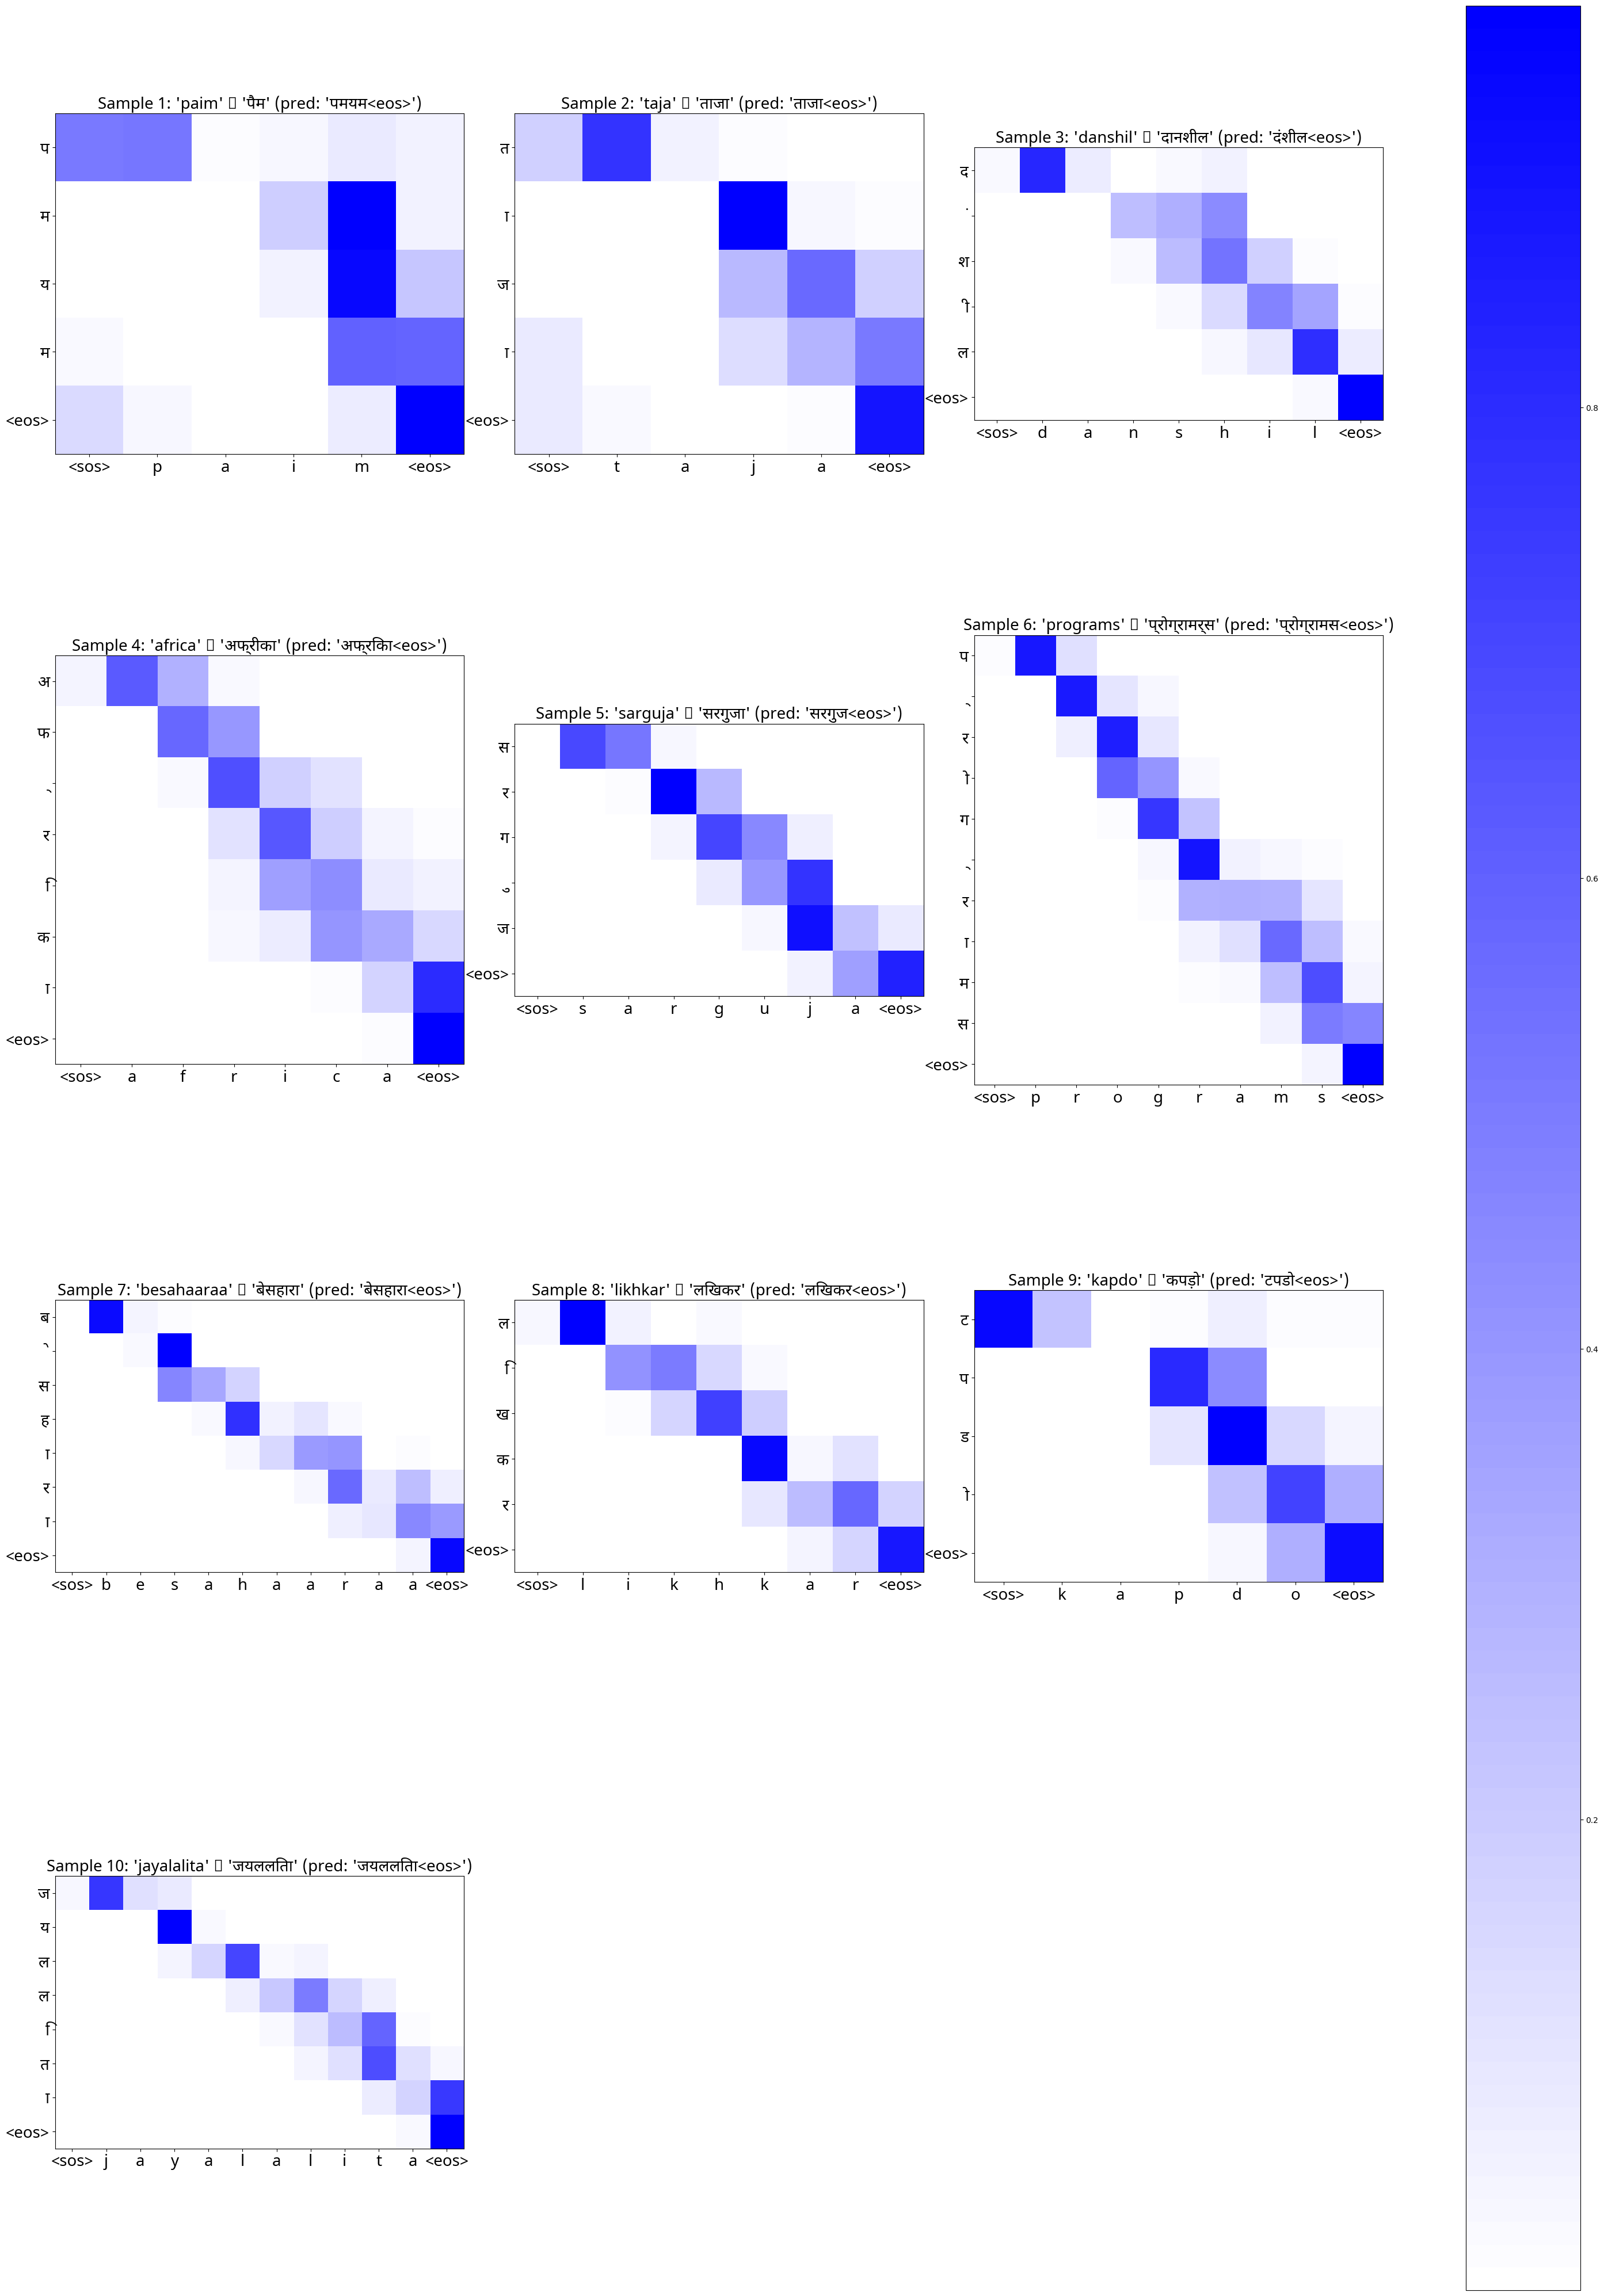

In [30]:
plot_attention_heatmap(model, test_loader, src_vocab, tgt_vocab, device, num_samples=10)

In [ ]:
import os
import json
import random
import torch
import wandb
from IPython.display import HTML

# 1) Sample Latin words
sampled = ["Damn", "world", "need", "model", "example"]
print("Sampled words:", sampled)

# 2) HTML Visualization for Attention Matrix
def create_interactive_connectivity(attn_matrix, input_seq, output_seq, filename="attention.html"):
    """
    Generates an interactive HTML visualization of the attention matrix.
    """
    html_template = """<!DOCTYPE html><html><head><meta charset="UTF-8"><title>Attention</title><style>
    body{font-family:'Arial Unicode MS','Noto Sans Devanagari',sans-serif;margin:20px;text-align:center;}
    .container{display:inline-block;}
    .controls{margin:12px;}
    .slider{width:180px;}
    .output-chars,.input-chars{display:flex;justify-content:center;margin:10px;}
    .char{padding:6px 10px;margin:3px;font-size:18px;position:relative;cursor:pointer;min-width:24px;transition:all .2s;}
    .output-char{background:#f0f0f0;border-radius:4px;}
    .input-char{background:#e0e0e0;border-radius:4px;}
    .selected{background:#4caf50;color:#fff;font-weight:bold;box-shadow:0 0 6px rgba(76,175,80,.5);}
    .highlighted{background:rgba(76,175,80,.3);transform:scale(1.1);}
    .connection-line{position:absolute;background:rgba(0,200,0,.5);height:3px;transform-origin:left center;z-index:-1;pointer-events:none;}
    </style></head><body>
    <div class="container">
        <div class="controls">
            Threshold:
            <input id="thr" type="range" min="0" max="100" value="30" class="slider">
            <span id="tv">0.30</span>
        </div>
        <div class="output-chars" id="outs"></div>
        <div class="input-chars" id="ins"></div>
    </div>
    <script>
    const A={attn_matrix}, IN={input_seq}, OUT={output_seq};
    let cur=0, thr=0.3;

    function init() {
        renderOut();
        renderIn();
        draw();
        document.getElementById('thr').oninput = e => {
            thr = e.target.value / 100;
            document.getElementById('tv').textContent = thr.toFixed(2);
            draw();
        };
        window.onresize = draw;
    }

    function renderOut() {
        let c = document.getElementById('outs');
        c.innerHTML = '';
        OUT.forEach((ch, i) => {
            let d = document.createElement('div');
            d.className = `char output-char ${i === cur ? 'selected' : ''}`;
            d.textContent = ch;
            d.dataset.i = i;
            d.onmouseover = d.onclick = () => {
                cur = i;
                renderOut();
                draw();
            };
            c.appendChild(d);
        });
    }

    function renderIn() {
        let c = document.getElementById('ins');
        c.innerHTML = '';
        IN.forEach((ch, i) => {
            let d = document.createElement('div');
            d.className = 'char input-char';
            d.textContent = ch;
            d.dataset.i = i;
            c.appendChild(d);
        });
    }

    function draw() {
        document.querySelectorAll('.connection-line').forEach(e => e.remove());
        document.querySelectorAll('.input-char').forEach(e => e.classList.remove('highlighted'));
        let o = document.querySelector(`.output-char[data-i="${cur}"]`);
        if (!o) return;

        let R = o.getBoundingClientRect(), W = A[cur], M = Math.max(...W);
        W.forEach((w, i) => {
            let n = w / M;
            if (n < thr) return;

            let inp = document.querySelector(`.input-char[data-i="${i}"]`);
            inp.classList.add('highlighted');

            let S = inp.getBoundingClientRect();
            let x1 = R.left + R.width / 2 - window.scrollX,
                y1 = R.top + R.height - window.scrollY,
                x2 = S.left + S.width / 2 - window.scrollX,
                y2 = S.top - window.scrollY;

            let L = Math.hypot(x2 - x1, y2 - y1),
                ang = Math.atan2(y2 - y1, x2 - x1) * 180 / Math.PI;

            let line = document.createElement('div');
            line.className = 'connection-line';
            Object.assign(line.style, {
                width: `${L}px`,
                left: `${x1}px`,
                top: `${y1}px`,
                transform: `rotate(${ang}deg)`,
                opacity: n
            });
            document.body.appendChild(line);
        });
    }

    document.addEventListener('DOMContentLoaded', init);
    </script></body></html>"""

    # Clean the attention matrix
    sanitized_matrix = []
    for row in attn_matrix:
        if hasattr(row, "cpu"):
            row = row.cpu().numpy()
        sanitized_matrix.append([float(x) for x in row])

    # Embed data into HTML
    attn_json = json.dumps(sanitized_matrix)
    inp_json = json.dumps(input_seq)
    out_json = json.dumps(output_seq)

    html = html_template.replace("{attn_matrix}", attn_json)\
                        .replace("{input_seq}", inp_json)\
                        .replace("{output_seq}", out_json)

    # Save to file
    with open(filename, "w", encoding="utf-8") as f:
        f.write(html)

    return filename

# 3) Generate W&B Attention Table
wandb.init(project="Deep_Learning_Assignment_3", resume="allow")
table = wandb.Table(columns=["Input (Latin)", "Prediction (Devanagari)", "Attention (HTML)"])

model.eval()
for i, latin in enumerate(sampled):
    attn_weights, pred_ids = get_attention_weights(model, latin, src_vocab, tgt_vocab, device)
    pred_str = tgt_vocab.decode(pred_ids, remove_special_tokens=True)

    # Generate HTML visualization
    html_file = create_interactive_connectivity(
        attn_matrix=attn_weights,
        input_seq=list(latin),
        output_seq=list(pred_str),
        filename=f"attn_{i}.html"
    )

    # Read and add HTML to table
    with open(html_file, "r", encoding="utf-8") as f:
        html_txt = f.read()
    table.add_data(latin, pred_str, wandb.Html(html_txt))
    os.remove(html_file)

# 4) Log Results to W&B
wandb.log({"Interactive_Attention_Table": table})
wandb.run.summary["Interactive_Attention_Examples"] = table

# 5) Optional: Display last HTML
display(HTML(html_file))
